# **Fake News Detection**

## Table of contents
* [Imports](#imports)
* [Data analysis](#data-analysis)
    * [WELFake](#2.1)
    * [Fake_news_net](#2.2)
    * [Fake True](#2.3)
* [Data preprocessing](#3)
    * [WELFake](#3.1)
        * [Bag of words](#3.1.1)
        * [Word 2 vec](#3.1.2)
        * [Split data](#3.1.3)
    * [Fake_news_net](#3.2)
        * [Bag of words](#3.2.1)
        * [Word 2 vec](#3.2.2)
        * [Split data](#3.2.3)
    * [Fake True](#3.3)
        * [Bag of words](#3.3.1)
        * [Word 2 vec](#3.3.2)
        * [Split data](#3.3.3)
* [Models](#4)
    * [WELFake](#4.1)
        * [Bag of words](#4.1.1)
        * [Word 2 vec](#4.1.2)
    * [Fake_news_net](#4.2)
        * [Bag of words](#4.2.1)
        * [Word 2 vec](#4.2.2)
    * [Fake True](#4.3)
        * [Bag of words](#4.3.1)
        * [Word 2 vec](#4.3.2)
* [Hyparameters tunning](#5)
    * [WELFake](#5.1)
        * [Bag of words](#5.1.1)
        * [Word 2 vec](#5.1.2)
    * [Fake_news_net](#5.2)
        * [Bag of words](#5.2.1)
        * [Word 2 vec](#5.2.2)
    * [Fake True](#5.3)
        * [Bag of words](#5.3.1)
        * [Word 2 vec](#5.3.2)
* [Cross-validation](#6)
    * [WELFake](#6.1)
        * [Bag of words](#6.1.1)
        * [Word 2 vec](#6.1.2)
    * [Fake_news_net](#6.2)
        * [Bag of words](#6.2.1)
        * [Word 2 vec](#6.2.2)
    * [Fake True](#6.3)
        * [Bag of words](#6.3.1)
        * [Word 2 vec](#6.3.2)

# **1. Imports** <a name="imports"></a>

In [1]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import nltk
import optuna

import torch
import torch.nn as nn
import torch.optim as optim

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

from ydata_profiling import ProfileReport
from wordcloud import WordCloud
from gensim.models import Word2Vec
from tqdm import tqdm


nltk.download('stopwords')
nltk.download('wordnet')

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/przemek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/przemek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
wel_fake = pd.read_csv('data/WELFake_Dataset.csv', index_col = 0)
fake_news_net = pd.read_csv('data/FakeNewsNet.csv', index_col=False)
true = pd.read_csv('data/true.csv', index_col=False)
fake = pd.read_csv('data/fake.csv', index_col=False)

# **2. Data analysis** <a name="data-analysis"></a>

In [3]:
def balance_plot(df, label, plot_name):
    df.groupby(label)[label].count().plot(kind='pie', autopct='%1.1f%%', title=plot_name)

In [4]:
stopwords = set(stopwords.words('english'))
def word_cloud_plot(df, groupby, agg_column):
    wc = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(df.groupby(groupby)[agg_column].sum()[0])
    plt.figure(figsize=(10,10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## **2.1 WEL Fake dataset** <a name="2.1"></a>

In [5]:
wel_fake

title  \
0      LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1                                                    NaN   
2      UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3      Bobby Jindal, raised Hindu, uses story of Chri...   
4      SATAN 2: Russia unvelis an image of its terrif...   
...                                                  ...   
72129  Russians steal research on Trump in hack of U....   
72130   WATCH: Giuliani Demands That Democrats Apolog...   
72131  Migrants Refuse To Leave Train At Refugee Camp...   
72132  Trump tussle gives unpopular Mexican leader mu...   
72133  Goldman Sachs Endorses Hillary Clinton For Pre...   

                                                    text  label  
0      No comment is expected from Barack Obama Membe...      1  
1         Did they post their votes for Hillary already?      1  
2       Now, most of the demonstrators gathered last ...      1  
3      A dozen politically active pastors came here f...      0  
4      The RS-28 Sarmat missile, dubbed Satan 2, will...      1  
...                                                  ...    ...  
72129  WASHINGTON (Reuters) - Hackers believed to be ...      0  
72130  You know, because in fantasyland Republicans n...      1  
72131  Migrants Refuse To Leave Train At Refugee Camp...      0  
72132  MEXICO CITY (Reuters) - Donald Trump’s combati...      0  
72133  Goldman Sachs Endorses Hillary Clinton For Pre...      1  

[72134 rows x 3 columns]

In [6]:
#ProfileReport(wel_fake, title='WELFake').to_file('WELFake.html')

In [7]:
missing_values = wel_fake.isnull().sum()
missing_values

title    558
text      39
label      0
dtype: int64

In [8]:
wel_fake.fillna(" ", inplace=True)
wel_fake.dropna(inplace=True)
wel_fake = wel_fake.reset_index(drop=True)

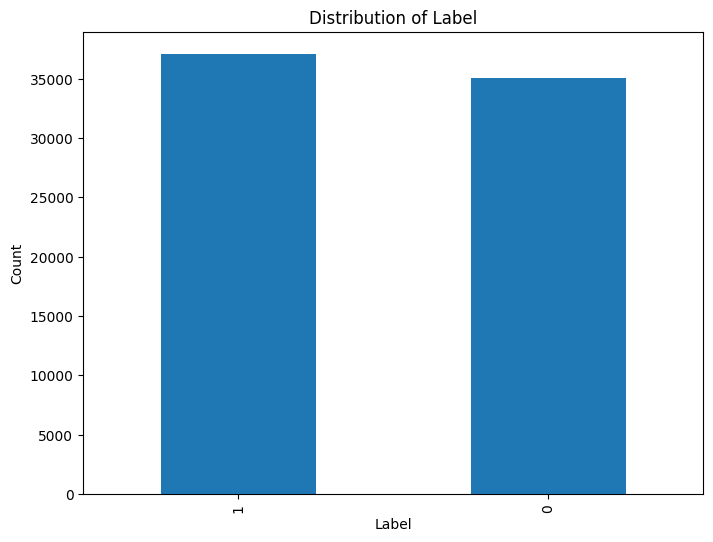

In [9]:
plt.figure(figsize=(8, 6))
wel_fake['label'].value_counts().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Label')
plt.show()

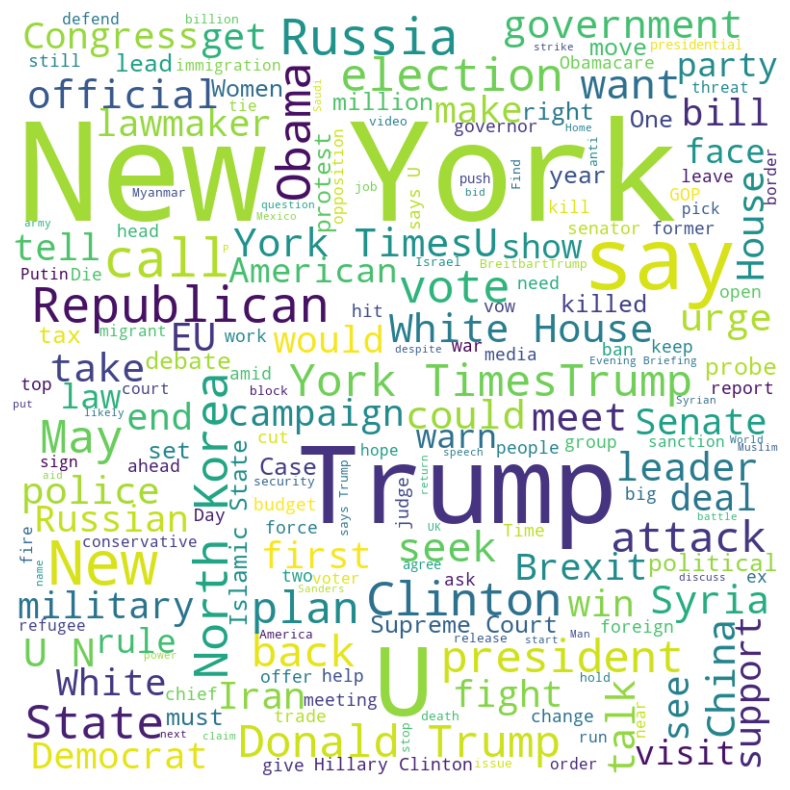

In [10]:
word_cloud_plot(wel_fake,'label', 'title')

## **2.2 Fake news net dataset** <a name="2.2"></a>

In [11]:
fake_news_net

title  \
0      Kandi Burruss Explodes Over Rape Accusation on...   
1      People's Choice Awards 2018: The best red carp...   
2      Sophia Bush Sends Sweet Birthday Message to 'O...   
3      Colombian singer Maluma sparks rumours of inap...   
4      Gossip Girl 10 Years Later: How Upper East Sid...   
...                                                  ...   
23191  Pippa Middleton wedding: In case you missed it...   
23192  Zayn Malik & Gigi Hadid’s Shocking Split: Why ...   
23193  Jessica Chastain Recalls the Moment Her Mother...   
23194  Tristan Thompson Feels "Dumped" After Khloé Ka...   
23195  Kelly Clarkson Performs a Medley of Kendrick L...   

                                                news_url  \
0      http://toofab.com/2017/05/08/real-housewives-a...   
1      https://www.today.com/style/see-people-s-choic...   
2      https://www.etonline.com/news/220806_sophia_bu...   
3      https://www.dailymail.co.uk/news/article-33655...   
4      https://www.zerchoo.com/entertainment/gossip-g...   
...                                                  ...   
23191  https://www.express.co.uk/news/royal/807049/pi...   
23192  hollywoodlife.com/2018/03/13/zayn-malik-gigi-h...   
23193  http://www.justjared.com/2018/01/17/jessica-ch...   
23194  www.intouchweekly.com/posts/tristan-thompson-f...   
23195  https://www.billboard.com/articles/news/bbma/8...   

               source_domain  tweet_num  real  
0                 toofab.com         42     1  
1              www.today.com          0     1  
2           www.etonline.com         63     1  
3        www.dailymail.co.uk         20     1  
4            www.zerchoo.com         38     1  
...                      ...        ...   ...  
23191      www.express.co.uk         52     1  
23192      hollywoodlife.com          7     0  
23193      www.justjared.com         26     1  
23194  www.intouchweekly.com         24     0  
23195      www.billboard.com         85     1  

[23196 rows x 5 columns]

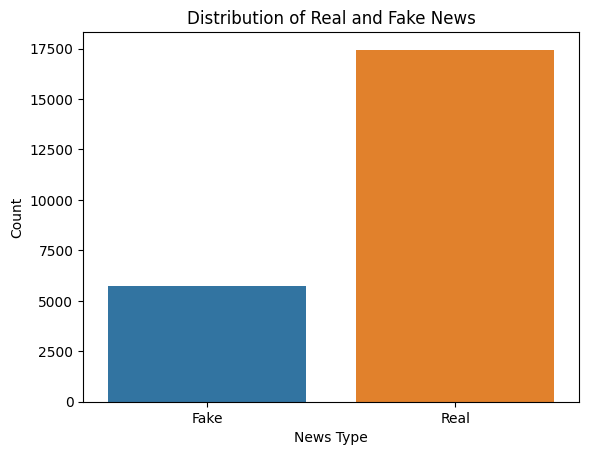

In [12]:
sns.countplot(x='real', data=fake_news_net)
plt.title('Distribution of Real and Fake News')
plt.xlabel('News Type')
plt.ylabel('Count')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

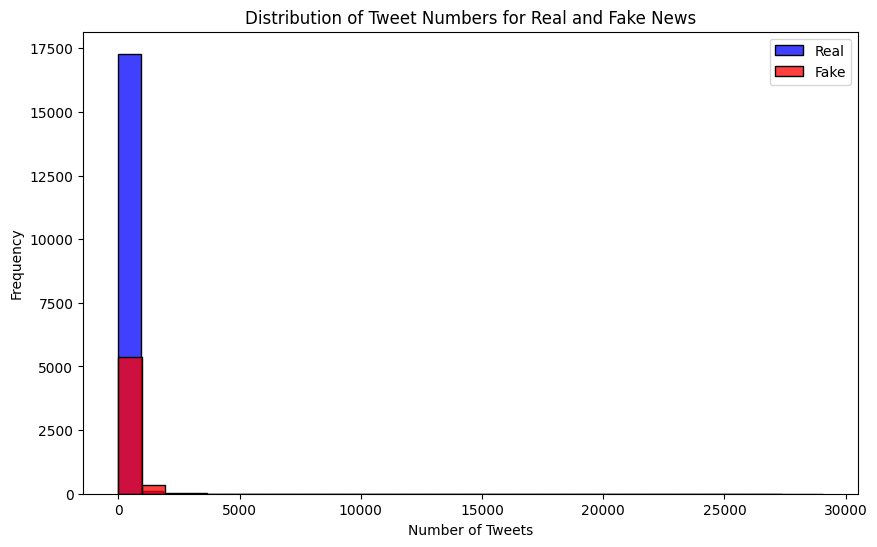

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(fake_news_net[fake_news_net['real'] == 1]['tweet_num'], bins=30, color='blue', label='Real')
sns.histplot(fake_news_net[fake_news_net['real'] == 0]['tweet_num'], bins=30, color='red', label='Fake')
plt.title('Distribution of Tweet Numbers for Real and Fake News')
plt.xlabel('Number of Tweets')
plt.ylabel('Frequency')
plt.legend()
plt.show()

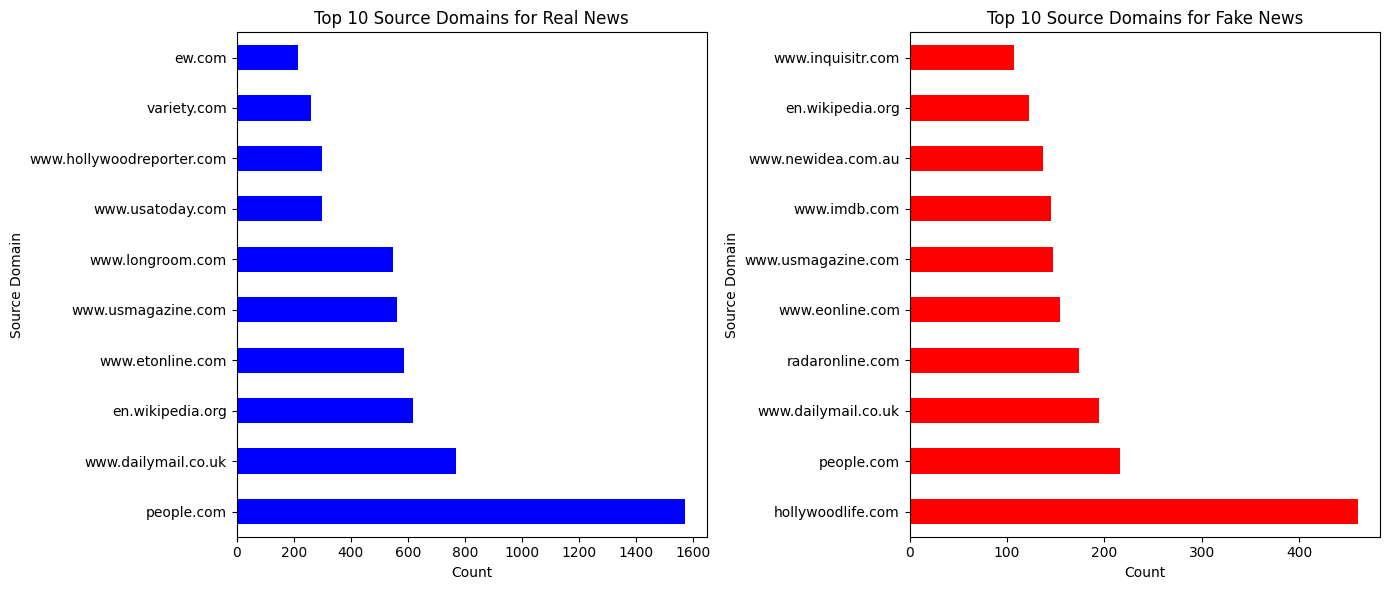

In [14]:
# Top 10 source domains for real and fake news
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
fake_news_net[fake_news_net['real'] == 1]['source_domain'].value_counts().head(10).plot(kind='barh', color='blue')
plt.title('Top 10 Source Domains for Real News')
plt.xlabel('Count')
plt.ylabel('Source Domain')

plt.subplot(1, 2, 2)
fake_news_net[fake_news_net['real'] == 0]['source_domain'].value_counts().head(10).plot(kind='barh', color='red')
plt.title('Top 10 Source Domains for Fake News')
plt.xlabel('Count')
plt.ylabel('Source Domain')

plt.tight_layout()
plt.show()

In [15]:
fake_news_net.isnull().sum()

title              0
news_url         330
source_domain    330
tweet_num          0
real               0
dtype: int64

In [16]:
#ProfileReport(fake_news_net, title='FakeNewsNet').to_file('FakeNewsNet.html')

Shape after removing missing values: (22866, 5)
Shape of balanced dataset: (10990, 5)


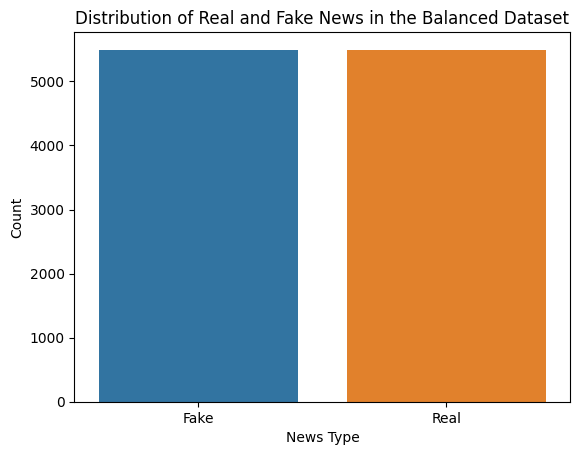

In [17]:
fake_news_net = fake_news_net.dropna()

print('Shape after removing missing values:', fake_news_net.shape)

real_news = fake_news_net[fake_news_net['real'] == 1]
fake_news = fake_news_net[fake_news_net['real'] == 0]

real_news_downsampled = real_news.sample(len(fake_news), random_state=1)

fake_news_net_balanced = pd.concat([real_news_downsampled, fake_news])

print('Shape of balanced dataset:', fake_news_net_balanced.shape)

sns.countplot(x='real', data=fake_news_net_balanced)
plt.title('Distribution of Real and Fake News in the Balanced Dataset')
plt.xlabel('News Type')
plt.ylabel('Count')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

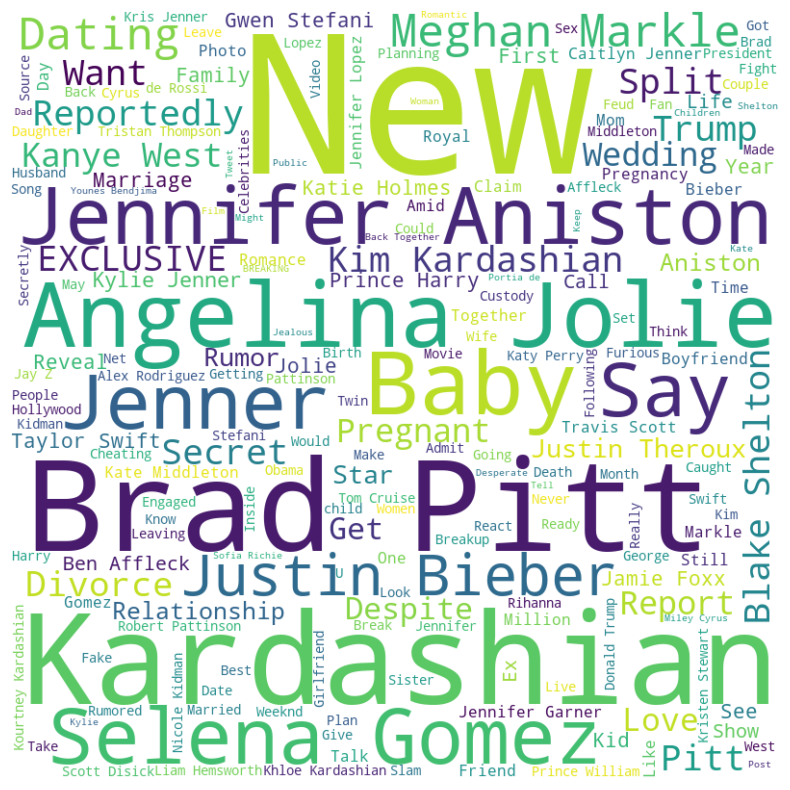

In [18]:
word_cloud_plot(fake_news_net,'real', 'title')

In [19]:
fake_news_net = fake_news_net_balanced

## **2.3 Fake and True dataset** <a name="2.3"></a>

In [20]:
fake['label'] = 0

true['label'] = 1

In [21]:
fake_true = pd.concat([fake, true]).reset_index(drop=True)

In [22]:
#ProfileReport(fake_true, title='FakeTrue').to_file('FakeTrue.html')

In [23]:
fake_true

title  \
0       Donald Trump Sends Out Embarrassing New Year’...   
1       Drunk Bragging Trump Staffer Started Russian ...   
2       Sheriff David Clarke Becomes An Internet Joke...   
3       Trump Is So Obsessed He Even Has Obama’s Name...   
4       Pope Francis Just Called Out Donald Trump Dur...   
...                                                  ...   
44893  'Fully committed' NATO backs new U.S. approach...   
44894  LexisNexis withdrew two products from Chinese ...   
44895  Minsk cultural hub becomes haven from authorities   
44896  Vatican upbeat on possibility of Pope Francis ...   
44897  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text    subject  \
0      Donald Trump just couldn t wish all Americans ...       News   
1      House Intelligence Committee Chairman Devin Nu...       News   
2      On Friday, it was revealed that former Milwauk...       News   
3      On Christmas day, Donald Trump announced that ...       News   
4      Pope Francis used his annual Christmas Day mes...       News   
...                                                  ...        ...   
44893  BRUSSELS (Reuters) - NATO allies on Tuesday we...  worldnews   
44894  LONDON (Reuters) - LexisNexis, a provider of l...  worldnews   
44895  MINSK (Reuters) - In the shadow of disused Sov...  worldnews   
44896  MOSCOW (Reuters) - Vatican Secretary of State ...  worldnews   
44897  JAKARTA (Reuters) - Indonesia will buy 11 Sukh...  worldnews   

                    date  label  
0      December 31, 2017      0  
1      December 31, 2017      0  
2      December 30, 2017      0  
3      December 29, 2017      0  
4      December 25, 2017      0  
...                  ...    ...  
44893   August 22, 2017       1  
44894   August 22, 2017       1  
44895   August 22, 2017       1  
44896   August 22, 2017       1  
44897   August 22, 2017       1  

[44898 rows x 5 columns]

In [24]:
fake_true.groupby(['subject', 'label']).count()

title   text   date
subject         label                     
Government News 0       1570   1570   1570
Middle-east     0        778    778    778
News            0       9050   9050   9050
US_News         0        783    783    783
left-news       0       4459   4459   4459
politics        0       6841   6841   6841
politicsNews    1      11272  11272  11272
worldnews       1      10145  10145  10145

In [25]:
fake_true.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

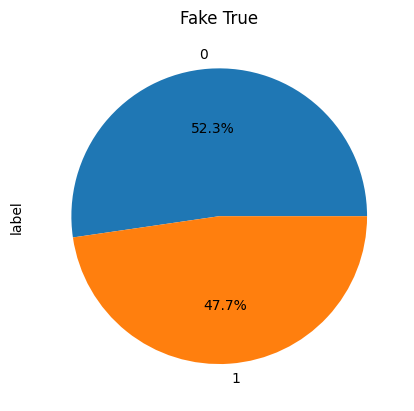

In [26]:
balance_plot(fake_true,'label', 'Fake True')

<AxesSubplot: >

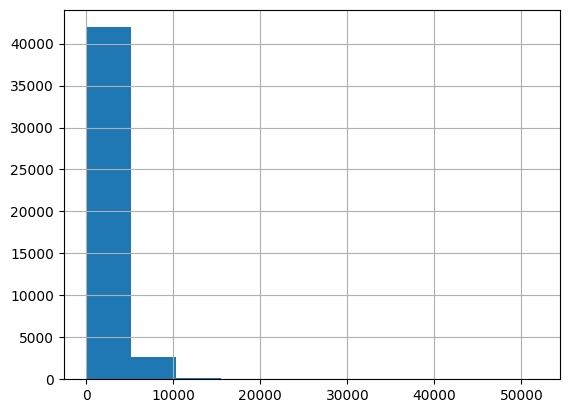

In [27]:
fake_true['text'].str.len().hist()

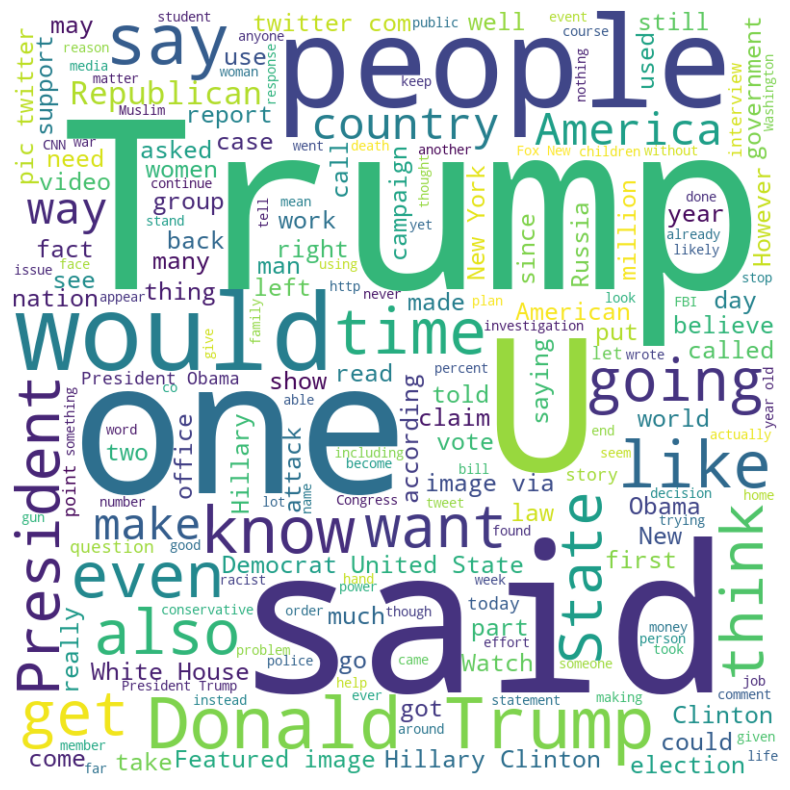

In [28]:
word_cloud_plot(fake_true,'label', 'text')

# **3. Data preprocessing** <a name="3"></a>

In [29]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]

    preprocessed_text = ' '.join(words)
    
    if preprocessed_text == "":
        preprocessed_text = "placeholder"

    return preprocessed_text

## **3.1 WEL Fake preprocessing** <a name="3.1"></a>

In [30]:
wel_fake['text'] = wel_fake['text'].apply(preprocess_text)
wel_fake.head()

title  \
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1                                                      
2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3  Bobby Jindal, raised Hindu, uses story of Chri...   
4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  comment expected barack obama member # fyf911 ...      1  
1                        post vote hillary already ?      1  
2  , demonstrator gathered last night exercising ...      1  
3  dozen politically active pastor came private d...      0  
4  rs-28 sarmat missile , dubbed satan 2 , replac...      1

### **3.1.1 Bag of Words** <a name="3.1.1"></a>

In [31]:
vectorizer = CountVectorizer(min_df=2, max_features=1000)

bow = vectorizer.fit_transform(wel_fake['text'])
X_bow_wel = bow.toarray()

X_bow_wel.shape

(72134, 1000)

### **Split Data**

In [32]:
y_wel = wel_fake['label']
X_train_bow_wel, X_test_bow_wel, y_train_bow_wel, y_test_bow_wel = train_test_split(X_bow_wel, y_wel, test_size=0.2, random_state=42)
X_train_bow_wel, X_val_bow_wel, y_train_bow_wel, y_val_bow_wel = train_test_split(X_train_bow_wel, y_train_bow_wel, test_size=0.2, random_state=42)

In [33]:
y_train_bow_wel.value_counts(normalize=True) #imbalance check

1    0.514697
0    0.485303
Name: label, dtype: float64

### **3.1.2 Word 2 Vec** <a name="3.1.2"></a>

In [34]:
sentences = wel_fake['text'].apply(lambda x: x.split())
model = Word2Vec(sentences, min_count=1)

print(model)

Word2Vec<vocab=375089, vector_size=100, alpha=0.025>


In [35]:
def w2v_train_test_prepatarion(data):
    X_train_vec = [] 
    for sentence in data:
        sentence_vec = []
        for word in sentence.split():
            if word in model.wv.key_to_index:
                sentence_vec.append(model.wv[word])
            else:
                sentence_vec.append(np.zeros(100)) #100 equal to vector_size in w2v_model
        X_train_vec.append(np.mean(sentence_vec, axis=0))
    return X_train_vec

In [36]:
X_w2v_wel = w2v_train_test_prepatarion(wel_fake['text'])

In [37]:
X_w2v_wel = pd.DataFrame(X_w2v_wel)

### **3.1.3 Split Data** <a name="3.1.3"></a>

In [38]:
X_train_w2v_wel, X_test_w2v_wel, y_train_w2v_wel, y_test_w2v_wel = train_test_split(X_w2v_wel, y_wel, test_size=0.2, random_state=42)
X_train_w2v_wel, X_val_w2v_wel, y_train_w2v_wel, y_val_w2v_wel = train_test_split(X_train_w2v_wel, y_train_w2v_wel, test_size=0.2, random_state=42)

In [39]:
y_train_w2v_wel.value_counts(normalize=True) #imbalance check

1    0.514697
0    0.485303
Name: label, dtype: float64

## **3.2 Fake News Net preprocessing** <a name="3.2"></a>

In [40]:
fake_news_net['title'] = fake_news_net['title'].apply(preprocess_text)
fake_news_net.head()

title  \
6378  'battle sex ' : accurate movie infamous tennis...   
7463  watch nikki bella get swept foot male stripper...   
9916  line awful review name recognition bye bye mon...   
9866  watch : r. kelly ’ alleged hostage break silen...   
5454  james franco , actor , sexual misconduct alleg...   

                                               news_url      source_domain  \
6378  https://www.usatoday.com/story/life/movies/201...   www.usatoday.com   
7463  https://newsflash.one/2018/07/20/watch-nikki-b...      newsflash.one   
9916  http://www.foxella.com/the-line-has-awful-revi...    www.foxella.com   
9866  https://theboxhouston.com/9747399/watch-r-kell...  theboxhouston.com   
5454  https://www.vox.com/a/sexual-harassment-assaul...        www.vox.com   

      tweet_num  real  
6378          0     1  
7463         10     1  
9916          0     1  
9866         18     1  
5454         19     1

### 3.2.1 Bag of Words <a name="3.2.1"></a>

In [41]:
vectorizer = CountVectorizer(min_df=2, max_features=1000)

bow = vectorizer.fit_transform(fake_news_net['title'])
X_bow_net = bow.toarray()

X_bow_net.shape

(10990, 1000)

In [145]:
y_net = fake_news_net['real']
X_train_bow_net, X_test_bow_net, y_train_bow_net, y_test_bow_net = train_test_split(X_bow_net, y_net, test_size=0.2, random_state=42)
X_train_bow_net, X_val_bow_net, y_train_bow_net, y_val_bow_net = train_test_split(X_train_bow_net, y_train_bow_net, test_size=0.2, random_state=42)

In [146]:
y_train_bow_net.value_counts(normalize=True) #imbalance check

1    0.505901
0    0.494099
Name: real, dtype: float64

### **3.2.2 Bag of Word 2 Vec** <a name="3.2.2"></a>

In [44]:
sentences = fake_news_net['title'].apply(lambda x: x.split())
model = Word2Vec(sentences, min_count=1)

print(model)

Word2Vec<vocab=12612, vector_size=100, alpha=0.025>


In [45]:
X_w2v_net = w2v_train_test_prepatarion(fake_news_net['title'])

### 3.2.3 Split Data <a name="3.2.3"></a>

In [147]:
X_train_w2v_net, X_test_w2v_net, y_train_w2v_net, y_test_w2v_net = train_test_split(X_w2v_net, y_net, test_size=0.2, random_state=42)
X_train_w2v_net, X_val_w2v_net, y_train_w2v_net, y_val_w2v_net = train_test_split(X_train_w2v_net, y_train_w2v_net, test_size=0.2, random_state=42)

In [148]:
y_train_w2v_net.value_counts(normalize=True) #imbalance check

1    0.505901
0    0.494099
Name: real, dtype: float64

## **3.3 Fake and True preprocessing** <a name="3.3"></a>

In [48]:
fake_true.duplicated().sum()

209

In [49]:
fake_true.drop_duplicates(inplace=True)

In [50]:
fake_true['text'] = fake_true['text'].apply(preprocess_text)
fake_true.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  donald trump wish american happy new year leav...    News   
1  house intelligence committee chairman devin nu...    News   
2  friday , revealed former milwaukee sheriff dav...    News   
3  christmas day , donald trump announced would b...    News   
4  pope francis used annual christmas day message...    News   

                date  label  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  
4  December 25, 2017      0

### **3.3.1 Bag of words** <a name="3.3.1"></a>

In [51]:
vectorizer = CountVectorizer(min_df=2, max_features=1000)

bow = vectorizer.fit_transform(fake_true['text'])
X_bow_ft = bow.toarray()

X_bow_ft.shape

(44689, 1000)

In [52]:
y = fake_true['label']
X_train_bow_ft, X_test_bow_ft, y_train_bow_ft, y_test_bow_ft = train_test_split(X_bow_ft, y, test_size=0.2, random_state=42)
X_train_bow_ft, X_val_bow_ft, y_train_bow_ft, y_val_bow_ft = train_test_split(X_train_bow_ft, y_train_bow_ft, test_size=0.2, random_state=42)

In [53]:
y_train_bow_ft.value_counts(normalize=True) #imbalance check

0    0.52458
1    0.47542
Name: label, dtype: float64

### **3.3.2 Word 2 Vec** <a name="3.3.2"></a>

In [54]:
sentences = fake_true['text'].apply(lambda x: x.split())
model = Word2Vec(sentences, min_count=1)

print(model)

Word2Vec<vocab=217341, vector_size=100, alpha=0.025>


In [55]:
X_w2v_ft = w2v_train_test_prepatarion(fake_true['text'])

### 3.3.3 Split Data <a name="3.3.3"></a>

In [56]:
y = fake_true['label']
X_train_w2v_ft, X_test_w2v_ft,y_train_w2v_ft, y_test_w2v_ft = train_test_split(X_w2v_ft, y, test_size=0.2, random_state=42)
X_train_w2v_ft, X_val_w2v_ft,y_train_w2v_ft, y_val_w2v_ft = train_test_split(X_train_w2v_ft, y_train_w2v_ft, test_size=0.2, random_state=42)

In [57]:
y_train_w2v_ft.value_counts(normalize=True) #imbalance check

0    0.52458
1    0.47542
Name: label, dtype: float64

## 4. Models <a name="4"></a>

In [58]:
device = (
    "cuda"
    if torch.cuda.is_available() else "cpu" )
print(f"Using {device} device")

Using cpu device


In [59]:
torch.set_default_dtype(torch.float32)

In [60]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs =torch.sigmoid( self.linear(x))
        return outputs

In [61]:
def train(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (inputs, target) in tqdm(enumerate(train_loader), desc="Epoch %s: " % (epoch+1), total=train_loader.__len__()):
            inputs = inputs.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), target)
            loss.backward()
            optimizer.step()
            
        model.eval()
        valid_loss = 0.0
        correct = 0
        with torch.no_grad():
            for inputs, target in valid_loader:
                inputs = inputs.to(device)
                target = target.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), target)
                valid_loss += loss.item() * inputs.size(0)
                pred = (outputs > 0.5).float() 
                correct += (pred.squeeze() == target).float().sum().item()
                
        valid_loss /= len(valid_loader.dataset)
        valid_acc = correct / len(valid_loader.dataset)
        print ('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}' 
               .format(epoch+1, num_epochs, loss.item(), valid_loss, valid_acc))

In [62]:
def predict(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, target in data_loader:
            inputs = inputs.to(device)
            target = target.to(device)
            outputs = model(inputs)
            pred = (outputs > 0.5).float() 
            predictions.append(pred.squeeze().cpu().numpy())
    predictions = np.concatenate(predictions)
    return predictions

In [63]:
class LoadDataset(Dataset): #created due to lack of memory
    def __init__(self, X, y, use_toarray=False):
        self.X = X
        self.y = y
        self.use_toarray = use_toarray

    def __getitem__(self, index):
        if self.use_toarray:
            X_dense = torch.tensor(self.X[index]).float()
        else:
            X_dense = torch.tensor(self.X.iloc[index]).float()
        y_dense = torch.tensor(self.y.iloc[index]).float()
        return X_dense, y_dense

    def __len__(self):
        return len(self.y)

In [64]:
lr=0.01
epochs_num=2
criterion = nn.BCELoss()

## 4.1 WELFake <a name="4.1"></a>

### 4.1.1 Bag of Words <a name="4.1.1"></a>

In [65]:
y_train_bow_wel = y_train_bow_wel.reset_index(drop=True)
y_val_bow_wel = y_val_bow_wel.reset_index(drop=True)
y_test_bow_wel = y_test_bow_wel.reset_index(drop=True)

In [66]:
valid_loader = LoadDataset(X_val_bow_wel, y_val_bow_wel, use_toarray=True)
val_loader_bow_wel= DataLoader(valid_loader, 
                           batch_size=32, 
                           shuffle=True)

train_loader = LoadDataset(X_train_bow_wel, y_train_bow_wel, use_toarray=True)
train_loader_bow_wel= DataLoader(train_loader, 
                             batch_size=32, 
                             shuffle=True)

In [67]:
model_bow_wel = LogisticRegression(input_dim=X_train_bow_wel.shape[1], output_dim=1)
model_bow_wel.to(device)
optimizer = torch.optim.Adam(model_bow_wel.parameters(), lr=lr)

In [68]:
%%time
train(model_bow_wel, train_loader_bow_wel, val_loader_bow_wel, criterion, optimizer, device, epochs_num)

Epoch 1: 100%|████████████████████████████| 1443/1443 [00:00<00:00, 1736.31it/s]


Epoch [1/2], Loss: 0.3265, Validation Loss: 0.2831, Validation Accuracy: 0.9288


Epoch 2: 100%|████████████████████████████| 1443/1443 [00:00<00:00, 2078.44it/s]


Epoch [2/2], Loss: 0.3605, Validation Loss: 0.2580, Validation Accuracy: 0.9395
CPU times: user 1.69 s, sys: 137 ms, total: 1.83 s
Wall time: 1.87 s


In [69]:
test_loader = LoadDataset(X_test_bow_wel, y_test_bow_wel, use_toarray=True)
test_loader_wel= DataLoader(test_loader, batch_size=32)

In [70]:
y_pred_wel = predict(model_bow_wel, test_loader_wel)

print(classification_report(y_test_bow_wel, y_pred_wel))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      7089
           1       0.93      0.96      0.95      7338

    accuracy                           0.94     14427
   macro avg       0.94      0.94      0.94     14427
weighted avg       0.94      0.94      0.94     14427



### 4.1.2 Word 2 vec <a name="4.1.2"></a>

In [71]:
y_train_w2v_wel = y_train_w2v_wel.reset_index(drop=True)
y_val_w2v_wel = y_val_w2v_wel.reset_index(drop=True)
y_test_w2v_wel = y_test_w2v_wel.reset_index(drop=True)

In [72]:
valid_loader = LoadDataset(X_val_w2v_wel, y_val_w2v_wel)
val_loader_w2v_wel= DataLoader(valid_loader, 
                           batch_size=32, 
                           shuffle=True)

train_loader = LoadDataset(X_train_w2v_wel, y_train_w2v_wel)
train_loader_w2v_wel= DataLoader(train_loader, 
                                 batch_size=32, 
                                 shuffle=True)

In [73]:
model_w2v_wel = LogisticRegression(input_dim=100, output_dim=1)
model_w2v_wel.to(device)
optimizer = torch.optim.Adam(model_w2v_wel.parameters(), lr=lr)

In [74]:
train(model_w2v_wel, train_loader_w2v_wel, val_loader_w2v_wel,  criterion, optimizer, device, epochs_num)

Epoch 1: 100%|█████████████████████████████| 1443/1443 [00:07<00:00, 206.14it/s]


Epoch [1/2], Loss: 0.3135, Validation Loss: 0.2030, Validation Accuracy: 0.9228


Epoch 2: 100%|█████████████████████████████| 1443/1443 [00:06<00:00, 206.38it/s]


Epoch [2/2], Loss: 0.1093, Validation Loss: 0.1915, Validation Accuracy: 0.9255


In [75]:
test_loader = LoadDataset(X_test_w2v_wel, y_test_w2v_wel)
test_loader_w2v= DataLoader(test_loader, batch_size=32)

In [76]:
y_pred_w2v = predict(model_w2v_wel, test_loader_w2v)

print(classification_report(y_test_w2v_wel, y_pred_w2v))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7089
           1       0.93      0.93      0.93      7338

    accuracy                           0.93     14427
   macro avg       0.93      0.93      0.93     14427
weighted avg       0.93      0.93      0.93     14427



## 4.2 Fake_news_net <a name="4.2"></a>

### 4.2.1 Bag of words <a name="4.2.1"></a>

In [77]:
y_train_bow_net = y_train_bow_net.reset_index(drop=True)
y_val_bow_net = y_val_bow_net.reset_index(drop=True)
y_test_bow_net = y_test_bow_net.reset_index(drop = True)

In [78]:
valid_loader = LoadDataset(X_val_bow_net, y_val_bow_net, use_toarray=True)
val_loader_bow_net= DataLoader(valid_loader, 
                           batch_size=32, 
                           shuffle=True)

train_loader = LoadDataset(X_train_bow_net, y_train_bow_net, use_toarray=True)
train_loader_bow_net= DataLoader(train_loader, 
                             batch_size=32, 
                             shuffle=True)

In [79]:
model_bow_net = LogisticRegression(input_dim=X_train_bow_net.shape[1], output_dim=1)
model_bow_net.to(device)
optimizer = torch.optim.Adam(model_bow_net.parameters(), lr=lr)

In [80]:
%%time
train(model_bow_net, train_loader_bow_net, val_loader_bow_net, criterion, optimizer, device, epochs_num)

Epoch 1: 100%|██████████████████████████████| 220/220 [00:00<00:00, 1985.54it/s]


Epoch [1/2], Loss: 0.4983, Validation Loss: 0.5107, Validation Accuracy: 0.7533


Epoch 2: 100%|██████████████████████████████| 220/220 [00:00<00:00, 2034.16it/s]

Epoch [2/2], Loss: 0.4048, Validation Loss: 0.4916, Validation Accuracy: 0.7555
CPU times: user 263 ms, sys: 4.46 ms, total: 267 ms
Wall time: 267 ms


In [81]:
test_loader = LoadDataset(X_test_bow_net, y_test_bow_net, use_toarray=True)
test_loader_net= DataLoader(test_loader, 
                            batch_size=32, 
                            shuffle=False)

In [82]:
y_pred_net = predict(model_bow_net, test_loader_net)

print(classification_report(y_test_bow_net, y_pred_net))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73      1094
           1       0.72      0.80      0.76      1104

    accuracy                           0.75      2198
   macro avg       0.75      0.74      0.74      2198
weighted avg       0.75      0.75      0.74      2198



### 4.2.2 Word 2 vec <a name="4.2.2"></a>

In [83]:
y_train_w2v_net = y_train_w2v_net.reset_index(drop=True)
y_val_w2v_net = y_val_w2v_net.reset_index(drop=True)
y_test_w2v_net = y_test_w2v_net.reset_index(drop = True)

In [89]:
valid_loader = LoadDataset(X_val_w2v_net, y_val_w2v_net, use_toarray=True)
val_loader_w2v_net= DataLoader(valid_loader, 
                           batch_size=32, 
                           shuffle=True)

train_loader = LoadDataset(X_train_w2v_net, y_train_w2v_net, use_toarray=True)
train_loader_w2v_net= DataLoader(train_loader, 
                             batch_size=32, 
                             shuffle=True)

In [90]:
model_w2v_net = LogisticRegression(input_dim=100, output_dim=1)
model_w2v_net.to(device)
optimizer = torch.optim.Adam(model_w2v_net.parameters(), lr=lr)

In [91]:
%%time
train(model_w2v_net, train_loader_w2v_net, val_loader_w2v_net, criterion, optimizer, device, epochs_num)

Epoch 1: 100%|██████████████████████████████| 220/220 [00:00<00:00, 1654.86it/s]


Epoch [1/2], Loss: 0.6293, Validation Loss: 0.6552, Validation Accuracy: 0.5975


Epoch 2: 100%|██████████████████████████████| 220/220 [00:00<00:00, 2284.39it/s]

Epoch [2/2], Loss: 0.5962, Validation Loss: 0.6346, Validation Accuracy: 0.6191
CPU times: user 268 ms, sys: 5.73 ms, total: 274 ms
Wall time: 272 ms


In [94]:
test_loader = LoadDataset(X_test_w2v_net, y_test_w2v_net, use_toarray=True)
test_loader_net= DataLoader(test_loader, 
                            batch_size=32, 
                            shuffle=False)

In [95]:
y_pred_net = predict(model_w2v_net, test_loader_net)

print(classification_report(y_test_w2v_net, y_pred_net))

              precision    recall  f1-score   support

           0       0.59      0.70      0.64      1094
           1       0.63      0.51      0.56      1104

    accuracy                           0.61      2198
   macro avg       0.61      0.61      0.60      2198
weighted avg       0.61      0.61      0.60      2198



## 4.3 Fake True <a name="4.3"></a>

### 4.3.1 Bag of words <a name="4.3.1"></a>

In [96]:
y_train_bow_ft = y_train_bow_ft.reset_index(drop=True)
y_val_bow_ft = y_val_bow_ft.reset_index(drop=True)
y_test_bow_ft = y_test_bow_ft.reset_index(drop=True)


In [97]:
valid_loader = LoadDataset(X_val_bow_ft, y_val_bow_ft, use_toarray=True)
val_loader_bow_ft= DataLoader(valid_loader, 
                          batch_size=32, 
                          shuffle=True)

train_loader = LoadDataset(X_train_bow_ft, y_train_bow_ft, use_toarray=True)
train_loader_bow_ft= DataLoader(train_loader, 
                            batch_size=32, 
                            shuffle=True)

In [98]:
model_bow_ft = LogisticRegression(input_dim=X_train_bow_ft.shape[1], output_dim=1)
model_bow_ft.to(device)
optimizer = torch.optim.Adam(model_bow_ft.parameters(), lr=lr)

In [99]:
%%time
train(model_bow_ft, train_loader_bow_ft, val_loader_bow_ft, criterion, optimizer, device, epochs_num)

Epoch 1: 100%|██████████████████████████████| 894/894 [00:00<00:00, 1659.58it/s]


Epoch [1/2], Loss: 0.1162, Validation Loss: 0.0352, Validation Accuracy: 0.9931


Epoch 2: 100%|██████████████████████████████| 894/894 [00:00<00:00, 2045.43it/s]


Epoch [2/2], Loss: 0.0112, Validation Loss: 0.0284, Validation Accuracy: 0.9938
CPU times: user 1.09 s, sys: 48.9 ms, total: 1.14 s
Wall time: 1.16 s


In [100]:
test_loader = LoadDataset(X_test_bow_ft, y_test_bow_ft, use_toarray=True)
test_loader_ft= DataLoader(test_loader, 
                            batch_size=32, 
                            shuffle=False)

In [101]:
y_pred_ft = predict(model_bow_ft, test_loader_ft)

print(classification_report(y_test_bow_ft, y_pred_ft))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4738
           1       1.00      0.99      0.99      4200

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



### 4.3.2 Word 2 vec <a name="4.3.2"></a>

In [102]:
y_train_w2v_ft = y_train_w2v_ft.reset_index(drop=True)
y_val_w2v_ft = y_val_w2v_ft.reset_index(drop=True)
y_test_w2v_ft = y_test_w2v_ft.reset_index(drop = True)

In [107]:
valid_loader = LoadDataset(X_val_w2v_ft, y_val_w2v_ft, use_toarray=True)
val_loader_w2v_ft= DataLoader(valid_loader, 
                           batch_size=32, 
                           shuffle=True)

train_loader = LoadDataset(X_train_w2v_ft, y_train_w2v_ft, use_toarray=True)
train_loader_w2v_ft= DataLoader(train_loader, 
                             batch_size=32, 
                             shuffle=True)

In [108]:
model_w2v_ft = LogisticRegression(input_dim=100, output_dim=1)
model_w2v_ft.to(device)
optimizer = torch.optim.Adam(model_w2v_ft.parameters(), lr=lr)

In [109]:
%%time
train(model_w2v_ft, train_loader_w2v_ft, val_loader_w2v_ft, criterion, optimizer, device, epochs_num)

Epoch 1: 100%|██████████████████████████████| 894/894 [00:00<00:00, 2179.07it/s]


Epoch [1/2], Loss: 0.0338, Validation Loss: 0.0839, Validation Accuracy: 0.9779


Epoch 2: 100%|██████████████████████████████| 894/894 [00:00<00:00, 2331.59it/s]


Epoch [2/2], Loss: 0.0679, Validation Loss: 0.0610, Validation Accuracy: 0.9849
CPU times: user 939 ms, sys: 12.3 ms, total: 951 ms
Wall time: 949 ms


In [110]:
test_loader = LoadDataset(X_test_w2v_ft, y_test_w2v_ft, use_toarray=True)
test_loader_ft= DataLoader(test_loader, 
                            batch_size=32, 
                            shuffle=False)

In [111]:
y_pred_ft = predict(model_w2v_ft, test_loader_ft)

print(classification_report(y_test_w2v_ft, y_pred_ft))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4738
           1       0.97      0.99      0.98      4200

    accuracy                           0.98      8938
   macro avg       0.98      0.98      0.98      8938
weighted avg       0.98      0.98      0.98      8938



## **5. Hyperparameters tunning** <a name="5"></a>

In [112]:
def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-3, 1e-1)
    epochs = trial.suggest_int('epochs', 5, 50)


    model = LogisticRegression(input_dim=X, output_dim=1)
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels)
            loss.backward()
            optimizer.step()

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            imputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).float().sum().item()

    return correct / total

In [113]:
def callback(study, trial):
    print("Trial finished with value: ", trial.value)

### 5.1 WELFake <a name="5.1"></a>

### 5.1.1 Bag of Words <a name="5.1.1"></a>

In [114]:
X = X_train_bow_wel.shape[1]
train_loader = train_loader_bow_wel
val_loader = val_loader_bow_wel

In [115]:
%%time
study_bow_wel = optuna.create_study(direction='maximize')
study_bow_wel.optimize(objective, n_trials=10, callbacks=[callback])

print('Best hyperparameters:', study_bow_wel.best_params)

Trial finished with value:  0.9428175359556402


[W 2023-06-08 23:13:54,752] Trial 1 failed with parameters: {'lr': 0.00721014147653945, 'epochs': 31} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/miniconda3/envs/torch/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/3s/03dr2xzx4ng8v50kkn_2yf500000gn/T/ipykernel_13662/3260209193.py", line 19, in objective
    optimizer.step()
  File "/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torch/optim/optimizer.py", line 140, in wrapper
    out = func(*args, **kwargs)
  File "/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torch/optim/optimizer.py", line 22, in _use_grad
    torch.set_grad_enabled(self.defaults['differentiable'])
  File "/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torch/autograd/grad_mode.py", line 229, in __init__
    torch._C._set_grad_enabled(mode)
KeyboardInterrupt
[W 2023-06-08 23:13:54,754] Trial 1 failed w

KeyboardInterrupt: 

In [116]:
optuna.visualization.plot_optimization_history(study_bow_wel)

### 5.1.2 Word 2 vec <a name="5.1.2"></a>

In [117]:
X = 100
train_loader = train_loader_w2v_wel
val_loader = val_loader_w2v_wel

In [118]:
%%time
study_w2v_wel = optuna.create_study(direction='maximize')
study_w2v_wel.optimize(objective, n_trials=10, callbacks=[callback])

print('Best hyperparameters:', study_w2v_wel.best_params)

Trial finished with value:  0.9268757581008491


[W 2023-06-08 23:15:08,235] Trial 1 failed with parameters: {'lr': 0.002744960276318101, 'epochs': 48} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/miniconda3/envs/torch/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/3s/03dr2xzx4ng8v50kkn_2yf500000gn/T/ipykernel_13662/3260209193.py", line 12, in objective
    for inputs, labels in train_loader:
  File "/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 628, in __next__
    data = self._next_data()
  File "/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 671, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_bat

KeyboardInterrupt: 

In [119]:
optuna.visualization.plot_optimization_history(study_w2v_wel)

### 5.2 Fake_new_net <a name="5.2"></a>

### 5.2.1 Bag of Words <a name="5.2.1"></a>

In [137]:
X = X_train_bow_net.shape[1]
train_loader = train_loader_bow_net
val_loader = val_loader_bow_net

In [138]:
%%time
study_bow_net = optuna.create_study(direction='maximize')
study_bow_net.optimize(objective, n_trials=10, callbacks=[callback])

print('Best hyperparameters:', study_bow_net.best_params)

Trial finished with value:  0.7396247868106879
Trial finished with value:  0.7538374076179648
Trial finished with value:  0.7407617964752701
Trial finished with value:  0.7561114269471291
Trial finished with value:  0.7350767481523593
Trial finished with value:  0.732802728823195
Trial finished with value:  0.7509948834565093
Trial finished with value:  0.7515633882888004


[W 2023-06-08 23:24:06,564] Trial 8 failed with parameters: {'lr': 0.025584437605907572, 'epochs': 48} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/miniconda3/envs/torch/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/3s/03dr2xzx4ng8v50kkn_2yf500000gn/T/ipykernel_13662/3260209193.py", line 12, in objective
    for inputs, labels in train_loader:
  File "/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 628, in __next__
    data = self._next_data()
  File "/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 671, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_bat

KeyboardInterrupt: 

In [139]:
optuna.visualization.plot_optimization_history(study_bow_net)

### 5.2.2 Word 2 vec <a name="5.2.2"></a>

In [140]:
X = 100
train_loader = train_loader_w2v_net
val_loader = val_loader_w2v_net

In [141]:
%%time
study_w2v_net = optuna.create_study(direction='maximize')
study_w2v_net.optimize(objective, n_trials=10, callbacks=[callback])

print('Best hyperparameters:', study_w2v_net.best_params)

Trial finished with value:  0.6515065378055713
Trial finished with value:  0.657191586128482
Trial finished with value:  0.6287663445139283
Trial finished with value:  0.641841955656623
Trial finished with value:  0.6156907333712337


[W 2023-06-08 23:24:18,961] Trial 6 failed with parameters: {'lr': 0.08819493016118585, 'epochs': 20} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/miniconda3/envs/torch/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/3s/03dr2xzx4ng8v50kkn_2yf500000gn/T/ipykernel_13662/3260209193.py", line 12, in objective
    for inputs, labels in train_loader:
  File "/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 628, in __next__
    data = self._next_data()
  File "/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 671, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
KeyboardInterrupt
[W 2023-06-08 23:24:18,961] Trial 6 failed with value None.


Trial finished with value:  0.657191586128482


KeyboardInterrupt: 

In [142]:
optuna.visualization.plot_optimization_history(study_w2v_net)

### 5.3 Fake True <a name="5.3"></a>

### 5.3.1 Bag of Words <a name="5.3.1"></a>

In [ ]:
X = X_train_bow_ft.shape[1]
train_loader = train_loader_bow_ft
val_loader = val_loader_bow_ft

In [ ]:
%%time
study_bow_ft = optuna.create_study(direction='maximize')
study_bow_ft.optimize(objective, n_trials=10, callbacks=[callback])

print('Best hyperparameters:', study_bow_ft.best_params)

In [ ]:
optuna.visualization.plot_optimization_history(study_bow_ft)

### 5.3.2 Word 2 vec <a name="5.3.2"></a>

In [ ]:
X = 100
train_loader = train_loader_w2v_ft
val_loader = val_loader_w2v_ft

In [ ]:
%%time
study_w2v_ft = optuna.create_study(direction='maximize')
study_w2v_ft.optimize(objective, n_trials=10, callbacks=[callback])

print('Best hyperparameters:', study_w2v_ft.best_params)

In [ ]:
optuna.visualization.plot_optimization_history(study_w2v_ft)

## 6. Cross-validation <a name="6"></a>

In [130]:
from sklearn.model_selection import StratifiedKFold

def train_one_fold(model, train_loader, criterion, optimizer, device):
    model.train()
    for batch_idx, (inputs, target) in tqdm(enumerate(train_loader), desc="Training: ", total=train_loader.__len__()):
        inputs = inputs.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), target)
        loss.backward()
        optimizer.step()

def validate_one_fold(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, target in valid_loader:
            inputs = inputs.to(device)
            target = target.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), target)
            valid_loss += loss.item() * inputs.size(0)
            pred = (outputs > 0.5).float() 
            correct += (pred.squeeze() == target).float().sum().item()

    valid_loss /= len(valid_loader.dataset)
    valid_acc = correct / len(valid_loader.dataset)
    print ('Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'.format(valid_loss, valid_acc))
    return valid_acc

def stratified_cross_validation(X, y,criterion, device, num_epochs):
    skf = StratifiedKFold(n_splits=5)
    acc_per_fold = []

    for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
        print(f"Training fold {fold+1}")
        
        X_train_fold, X_valid_fold = X[train_index], X[valid_index]
        y_train_fold, y_valid_fold = y[train_index], y[valid_index]
        
        model = LogisticRegression(input_dim=X_train_fold.shape[1], output_dim=1)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        train_dataset = LoadDataset(X_train_fold, y_train_fold, use_toarray=True)
        valid_dataset = LoadDataset(X_valid_fold, y_valid_fold, use_toarray=True)
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
        
        model.to(device)
        
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}")
            train_one_fold(model, train_loader, criterion, optimizer, device)
            acc_per_fold.append(validate_one_fold(model, valid_loader, criterion, device))
    avg_acc = sum(acc_per_fold) / len(acc_per_fold)
    print('Average accuracy:', avg_acc)

### 6.1 WELFake <a name="6.1"></a> 

### 6.1.1 Bag of words <a name="6.1.1"></a>

In [131]:
lr = study_bow_wel.best_params['lr']
epochs_num = study_bow_wel.best_params['epochs']

In [132]:
stratified_cross_validation(X_bow_wel, y_wel, criterion, device, epochs_num)

Training fold 1
Epoch 1


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 1980.46it/s]


Validation Loss: 0.1927, Validation Accuracy: 0.9420
Epoch 2


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2079.47it/s]


Validation Loss: 0.2028, Validation Accuracy: 0.9446
Epoch 3


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2076.37it/s]


Validation Loss: 0.2099, Validation Accuracy: 0.9436
Epoch 4


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2070.17it/s]


Validation Loss: 0.2223, Validation Accuracy: 0.9447
Epoch 5


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2074.77it/s]


Validation Loss: 0.2247, Validation Accuracy: 0.9459
Epoch 6


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2073.53it/s]


Validation Loss: 0.2319, Validation Accuracy: 0.9431
Epoch 7


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2074.94it/s]


Validation Loss: 0.2194, Validation Accuracy: 0.9445
Epoch 8


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2047.58it/s]


Validation Loss: 0.2336, Validation Accuracy: 0.9440
Epoch 9


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 1929.40it/s]


Validation Loss: 0.2285, Validation Accuracy: 0.9430
Epoch 10


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 1988.33it/s]


Validation Loss: 0.2214, Validation Accuracy: 0.9439
Epoch 11


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2053.36it/s]


Validation Loss: 0.2225, Validation Accuracy: 0.9430
Epoch 12


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2072.91it/s]


Validation Loss: 0.2409, Validation Accuracy: 0.9434
Epoch 13


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2070.59it/s]


Validation Loss: 0.2381, Validation Accuracy: 0.9443
Epoch 14


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2067.42it/s]


Validation Loss: 0.2127, Validation Accuracy: 0.9445
Epoch 15


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2077.16it/s]


Validation Loss: 0.2382, Validation Accuracy: 0.9407
Epoch 16


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2071.69it/s]


Validation Loss: 0.2130, Validation Accuracy: 0.9454
Epoch 17


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2073.60it/s]


Validation Loss: 0.2336, Validation Accuracy: 0.9441
Epoch 18


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2034.86it/s]


Validation Loss: 0.2501, Validation Accuracy: 0.9418
Epoch 19


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2048.62it/s]


Validation Loss: 0.2823, Validation Accuracy: 0.9294
Epoch 20


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2060.76it/s]


Validation Loss: 0.2242, Validation Accuracy: 0.9425
Epoch 21


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2032.19it/s]


Validation Loss: 0.2229, Validation Accuracy: 0.9445
Epoch 22


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2067.22it/s]


Validation Loss: 0.2416, Validation Accuracy: 0.9423
Epoch 23


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2066.67it/s]


Validation Loss: 0.2211, Validation Accuracy: 0.9450
Epoch 24


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2051.68it/s]


Validation Loss: 0.2230, Validation Accuracy: 0.9460
Epoch 25


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2061.11it/s]


Validation Loss: 0.2619, Validation Accuracy: 0.9360
Epoch 26


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2064.72it/s]


Validation Loss: 0.2285, Validation Accuracy: 0.9443
Epoch 27


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2024.21it/s]


Validation Loss: 0.2321, Validation Accuracy: 0.9434
Epoch 28


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2038.22it/s]


Validation Loss: 0.2297, Validation Accuracy: 0.9413
Epoch 29


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2043.85it/s]


Validation Loss: 0.2356, Validation Accuracy: 0.9443
Epoch 30


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2063.70it/s]


Validation Loss: 0.2130, Validation Accuracy: 0.9430
Epoch 31


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2043.73it/s]


Validation Loss: 0.3897, Validation Accuracy: 0.9094
Epoch 32


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2043.29it/s]


Validation Loss: 0.2602, Validation Accuracy: 0.9418
Epoch 33


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2063.33it/s]


Validation Loss: 0.2196, Validation Accuracy: 0.9439
Epoch 34


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2039.44it/s]


Validation Loss: 0.2286, Validation Accuracy: 0.9439
Epoch 35


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2022.74it/s]


Validation Loss: 0.2192, Validation Accuracy: 0.9466
Epoch 36


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2046.31it/s]


Validation Loss: 0.2243, Validation Accuracy: 0.9434
Epoch 37


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2062.98it/s]


Validation Loss: 0.2248, Validation Accuracy: 0.9427
Epoch 38


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2059.77it/s]


Validation Loss: 0.2315, Validation Accuracy: 0.9427
Epoch 39


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2046.08it/s]


Validation Loss: 0.2338, Validation Accuracy: 0.9425
Epoch 40


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2028.34it/s]


Validation Loss: 0.2665, Validation Accuracy: 0.9397
Epoch 41


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2045.48it/s]


Validation Loss: 0.2228, Validation Accuracy: 0.9452
Epoch 42


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2063.37it/s]


Validation Loss: 0.2750, Validation Accuracy: 0.9312
Epoch 43


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2058.30it/s]


Validation Loss: 0.2103, Validation Accuracy: 0.9429
Epoch 44


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2027.33it/s]


Validation Loss: 0.2366, Validation Accuracy: 0.9442
Epoch 45


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2058.25it/s]


Validation Loss: 0.2358, Validation Accuracy: 0.9425
Epoch 46


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2052.65it/s]


Validation Loss: 0.2432, Validation Accuracy: 0.9420
Epoch 47


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2059.84it/s]


Validation Loss: 0.2399, Validation Accuracy: 0.9426
Epoch 48


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2058.28it/s]


Validation Loss: 0.2311, Validation Accuracy: 0.9423
Epoch 49


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2044.84it/s]


Validation Loss: 0.2262, Validation Accuracy: 0.9407
Training fold 2
Epoch 1


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 1971.27it/s]


Validation Loss: 0.1765, Validation Accuracy: 0.9421
Epoch 2


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2068.35it/s]


Validation Loss: 0.1820, Validation Accuracy: 0.9434
Epoch 3


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2071.63it/s]


Validation Loss: 0.1830, Validation Accuracy: 0.9451
Epoch 4


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2079.03it/s]


Validation Loss: 0.1925, Validation Accuracy: 0.9412
Epoch 5


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2064.56it/s]


Validation Loss: 0.1847, Validation Accuracy: 0.9444
Epoch 6


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2069.76it/s]


Validation Loss: 0.1844, Validation Accuracy: 0.9444
Epoch 7


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2044.70it/s]


Validation Loss: 0.2039, Validation Accuracy: 0.9462
Epoch 8


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2082.96it/s]


Validation Loss: 0.1869, Validation Accuracy: 0.9461
Epoch 9


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2069.22it/s]


Validation Loss: 0.1907, Validation Accuracy: 0.9423
Epoch 10


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2061.90it/s]


Validation Loss: 0.1866, Validation Accuracy: 0.9478
Epoch 11


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2072.51it/s]


Validation Loss: 0.1962, Validation Accuracy: 0.9448
Epoch 12


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2082.71it/s]


Validation Loss: 0.2205, Validation Accuracy: 0.9423
Epoch 13


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2064.41it/s]


Validation Loss: 0.1883, Validation Accuracy: 0.9484
Epoch 14


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2072.79it/s]


Validation Loss: 0.2012, Validation Accuracy: 0.9439
Epoch 15


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2065.76it/s]


Validation Loss: 0.2015, Validation Accuracy: 0.9458
Epoch 16


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2073.21it/s]


Validation Loss: 0.1858, Validation Accuracy: 0.9445
Epoch 17


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2043.43it/s]


Validation Loss: 0.1892, Validation Accuracy: 0.9451
Epoch 18


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2055.13it/s]


Validation Loss: 0.2098, Validation Accuracy: 0.9463
Epoch 19


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2079.26it/s]


Validation Loss: 0.1982, Validation Accuracy: 0.9461
Epoch 20


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2048.36it/s]


Validation Loss: 0.2209, Validation Accuracy: 0.9432
Epoch 21


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2082.12it/s]


Validation Loss: 0.1878, Validation Accuracy: 0.9447
Epoch 22


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2074.15it/s]


Validation Loss: 0.2047, Validation Accuracy: 0.9449
Epoch 23


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2053.00it/s]


Validation Loss: 0.1869, Validation Accuracy: 0.9448
Epoch 24


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2057.81it/s]


Validation Loss: 0.1776, Validation Accuracy: 0.9445
Epoch 25


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2055.19it/s]


Validation Loss: 0.1988, Validation Accuracy: 0.9466
Epoch 26


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2070.70it/s]


Validation Loss: 0.1938, Validation Accuracy: 0.9439
Epoch 27


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2073.97it/s]


Validation Loss: 0.1940, Validation Accuracy: 0.9452
Epoch 28


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2077.04it/s]


Validation Loss: 0.1829, Validation Accuracy: 0.9474
Epoch 29


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2030.75it/s]


Validation Loss: 0.1996, Validation Accuracy: 0.9462
Epoch 30


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2047.81it/s]


Validation Loss: 0.1839, Validation Accuracy: 0.9453
Epoch 31


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2069.95it/s]


Validation Loss: 0.1883, Validation Accuracy: 0.9437
Epoch 32


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2066.32it/s]


Validation Loss: 0.1845, Validation Accuracy: 0.9461
Epoch 33


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2064.32it/s]


Validation Loss: 0.1949, Validation Accuracy: 0.9431
Epoch 34


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2072.06it/s]


Validation Loss: 0.2422, Validation Accuracy: 0.9375
Epoch 35


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2054.30it/s]


Validation Loss: 0.1960, Validation Accuracy: 0.9445
Epoch 36


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2054.20it/s]


Validation Loss: 0.1916, Validation Accuracy: 0.9442
Epoch 37


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2070.36it/s]


Validation Loss: 0.1848, Validation Accuracy: 0.9466
Epoch 38


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2073.98it/s]


Validation Loss: 0.1966, Validation Accuracy: 0.9444
Epoch 39


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2075.86it/s]


Validation Loss: 0.1944, Validation Accuracy: 0.9450
Epoch 40


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2061.47it/s]


Validation Loss: 0.2001, Validation Accuracy: 0.9461
Epoch 41


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2031.05it/s]


Validation Loss: 0.1881, Validation Accuracy: 0.9475
Epoch 42


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2071.07it/s]


Validation Loss: 0.1868, Validation Accuracy: 0.9443
Epoch 43


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2068.67it/s]


Validation Loss: 0.1812, Validation Accuracy: 0.9436
Epoch 44


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2070.42it/s]


Validation Loss: 0.1937, Validation Accuracy: 0.9438
Epoch 45


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2056.79it/s]


Validation Loss: 0.1906, Validation Accuracy: 0.9444
Epoch 46


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2066.26it/s]


Validation Loss: 0.1853, Validation Accuracy: 0.9425
Epoch 47


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2051.62it/s]


Validation Loss: 0.1848, Validation Accuracy: 0.9462
Epoch 48


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2058.93it/s]


Validation Loss: 0.1876, Validation Accuracy: 0.9477
Epoch 49


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2069.75it/s]


Validation Loss: 0.1799, Validation Accuracy: 0.9450
Training fold 3
Epoch 1


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 1973.95it/s]


Validation Loss: 0.1816, Validation Accuracy: 0.9420
Epoch 2


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2030.51it/s]


Validation Loss: 0.1891, Validation Accuracy: 0.9414
Epoch 3


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2056.72it/s]


Validation Loss: 0.1872, Validation Accuracy: 0.9430
Epoch 4


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2061.96it/s]


Validation Loss: 0.2038, Validation Accuracy: 0.9423
Epoch 5


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2044.51it/s]


Validation Loss: 0.1960, Validation Accuracy: 0.9437
Epoch 6


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2039.48it/s]


Validation Loss: 0.2286, Validation Accuracy: 0.9384
Epoch 7


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2065.30it/s]


Validation Loss: 0.2149, Validation Accuracy: 0.9382
Epoch 8


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2074.50it/s]


Validation Loss: 0.2207, Validation Accuracy: 0.9412
Epoch 9


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2067.76it/s]


Validation Loss: 0.1905, Validation Accuracy: 0.9444
Epoch 10


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2053.82it/s]


Validation Loss: 0.1990, Validation Accuracy: 0.9450
Epoch 11


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2037.17it/s]


Validation Loss: 0.2168, Validation Accuracy: 0.9397
Epoch 12


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2053.12it/s]


Validation Loss: 0.1989, Validation Accuracy: 0.9416
Epoch 13


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2060.08it/s]


Validation Loss: 0.2108, Validation Accuracy: 0.9436
Epoch 14


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2065.51it/s]


Validation Loss: 0.2164, Validation Accuracy: 0.9432
Epoch 15


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2068.75it/s]


Validation Loss: 0.2047, Validation Accuracy: 0.9446
Epoch 16


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2022.23it/s]


Validation Loss: 0.2026, Validation Accuracy: 0.9421
Epoch 17


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2053.42it/s]


Validation Loss: 0.1969, Validation Accuracy: 0.9439
Epoch 18


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2067.09it/s]


Validation Loss: 0.2063, Validation Accuracy: 0.9414
Epoch 19


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2067.00it/s]


Validation Loss: 0.2090, Validation Accuracy: 0.9403
Epoch 20


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2047.35it/s]


Validation Loss: 0.2278, Validation Accuracy: 0.9405
Epoch 21


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2049.07it/s]


Validation Loss: 0.2205, Validation Accuracy: 0.9427
Epoch 22


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2002.69it/s]


Validation Loss: 0.2100, Validation Accuracy: 0.9435
Epoch 23


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2057.38it/s]


Validation Loss: 0.2163, Validation Accuracy: 0.9411
Epoch 24


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2053.11it/s]


Validation Loss: 0.2040, Validation Accuracy: 0.9428
Epoch 25


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2063.00it/s]


Validation Loss: 0.1993, Validation Accuracy: 0.9441
Epoch 26


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2064.96it/s]


Validation Loss: 0.2151, Validation Accuracy: 0.9420
Epoch 27


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2063.94it/s]


Validation Loss: 0.2004, Validation Accuracy: 0.9445
Epoch 28


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2055.16it/s]


Validation Loss: 0.2069, Validation Accuracy: 0.9422
Epoch 29


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2048.56it/s]


Validation Loss: 0.1993, Validation Accuracy: 0.9445
Epoch 30


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2061.16it/s]


Validation Loss: 0.2295, Validation Accuracy: 0.9407
Epoch 31


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2065.75it/s]


Validation Loss: 0.2111, Validation Accuracy: 0.9430
Epoch 32


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2062.43it/s]


Validation Loss: 0.2079, Validation Accuracy: 0.9423
Epoch 33


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2066.25it/s]


Validation Loss: 0.1991, Validation Accuracy: 0.9430
Epoch 34


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2068.99it/s]


Validation Loss: 0.2097, Validation Accuracy: 0.9436
Epoch 35


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2040.00it/s]


Validation Loss: 0.1932, Validation Accuracy: 0.9426
Epoch 36


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2066.95it/s]


Validation Loss: 0.2053, Validation Accuracy: 0.9429
Epoch 37


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2055.83it/s]


Validation Loss: 0.2299, Validation Accuracy: 0.9398
Epoch 38


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2063.73it/s]


Validation Loss: 0.2195, Validation Accuracy: 0.9431
Epoch 39


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2065.39it/s]


Validation Loss: 0.2227, Validation Accuracy: 0.9355
Epoch 40


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2066.14it/s]


Validation Loss: 0.2027, Validation Accuracy: 0.9441
Epoch 41


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2067.51it/s]


Validation Loss: 0.2084, Validation Accuracy: 0.9405
Epoch 42


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2055.77it/s]


Validation Loss: 0.2131, Validation Accuracy: 0.9414
Epoch 43


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 1998.76it/s]


Validation Loss: 0.2051, Validation Accuracy: 0.9432
Epoch 44


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2059.39it/s]


Validation Loss: 0.2062, Validation Accuracy: 0.9416
Epoch 45


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2047.11it/s]


Validation Loss: 0.2035, Validation Accuracy: 0.9441
Epoch 46


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2068.68it/s]


Validation Loss: 0.2146, Validation Accuracy: 0.9395
Epoch 47


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2054.91it/s]


Validation Loss: 0.2053, Validation Accuracy: 0.9434
Epoch 48


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2059.32it/s]


Validation Loss: 0.2177, Validation Accuracy: 0.9397
Epoch 49


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2063.46it/s]


Validation Loss: 0.2041, Validation Accuracy: 0.9434
Training fold 4
Epoch 1


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2001.72it/s]


Validation Loss: 0.1973, Validation Accuracy: 0.9423
Epoch 2


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2068.15it/s]


Validation Loss: 0.2513, Validation Accuracy: 0.9362
Epoch 3


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2057.60it/s]


Validation Loss: 0.1982, Validation Accuracy: 0.9460
Epoch 4


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2066.76it/s]


Validation Loss: 0.2178, Validation Accuracy: 0.9437
Epoch 5


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2067.96it/s]


Validation Loss: 0.2058, Validation Accuracy: 0.9461
Epoch 6


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2069.38it/s]


Validation Loss: 0.2186, Validation Accuracy: 0.9432
Epoch 7


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2071.10it/s]


Validation Loss: 0.2277, Validation Accuracy: 0.9434
Epoch 8


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2053.17it/s]


Validation Loss: 0.2325, Validation Accuracy: 0.9448
Epoch 9


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2071.18it/s]


Validation Loss: 0.2255, Validation Accuracy: 0.9432
Epoch 10


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2071.21it/s]


Validation Loss: 0.2302, Validation Accuracy: 0.9424
Epoch 11


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2073.67it/s]


Validation Loss: 0.2305, Validation Accuracy: 0.9448
Epoch 12


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2074.50it/s]


Validation Loss: 0.2536, Validation Accuracy: 0.9376
Epoch 13


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2057.99it/s]


Validation Loss: 0.2178, Validation Accuracy: 0.9435
Epoch 14


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2071.65it/s]


Validation Loss: 0.2242, Validation Accuracy: 0.9441
Epoch 15


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2048.60it/s]


Validation Loss: 0.2099, Validation Accuracy: 0.9454
Epoch 16


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2036.75it/s]


Validation Loss: 0.2253, Validation Accuracy: 0.9437
Epoch 17


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2068.54it/s]


Validation Loss: 0.2223, Validation Accuracy: 0.9457
Epoch 18


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2054.78it/s]


Validation Loss: 0.2108, Validation Accuracy: 0.9449
Epoch 19


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2069.47it/s]


Validation Loss: 0.2178, Validation Accuracy: 0.9476
Epoch 20


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2034.66it/s]


Validation Loss: 0.2218, Validation Accuracy: 0.9448
Epoch 21


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2060.84it/s]


Validation Loss: 0.2192, Validation Accuracy: 0.9424
Epoch 22


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2053.87it/s]


Validation Loss: 0.2208, Validation Accuracy: 0.9422
Epoch 23


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2018.76it/s]


Validation Loss: 0.2089, Validation Accuracy: 0.9450
Epoch 24


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2037.58it/s]


Validation Loss: 0.2115, Validation Accuracy: 0.9468
Epoch 25


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2081.65it/s]


Validation Loss: 0.2311, Validation Accuracy: 0.9412
Epoch 26


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2062.81it/s]


Validation Loss: 0.2182, Validation Accuracy: 0.9453
Epoch 27


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2069.63it/s]


Validation Loss: 0.2150, Validation Accuracy: 0.9445
Epoch 28


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2060.31it/s]


Validation Loss: 0.2247, Validation Accuracy: 0.9461
Epoch 29


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2069.08it/s]


Validation Loss: 0.2113, Validation Accuracy: 0.9451
Epoch 30


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2073.07it/s]


Validation Loss: 0.2100, Validation Accuracy: 0.9468
Epoch 31


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2072.23it/s]


Validation Loss: 0.2091, Validation Accuracy: 0.9468
Epoch 32


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2079.05it/s]


Validation Loss: 0.2255, Validation Accuracy: 0.9436
Epoch 33


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2057.13it/s]


Validation Loss: 0.2227, Validation Accuracy: 0.9425
Epoch 34


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2082.51it/s]


Validation Loss: 0.2082, Validation Accuracy: 0.9468
Epoch 35


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2074.07it/s]


Validation Loss: 0.2152, Validation Accuracy: 0.9468
Epoch 36


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2074.23it/s]


Validation Loss: 0.2196, Validation Accuracy: 0.9420
Epoch 37


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2073.12it/s]


Validation Loss: 0.2216, Validation Accuracy: 0.9450
Epoch 38


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2060.87it/s]


Validation Loss: 0.2107, Validation Accuracy: 0.9448
Epoch 39


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2019.44it/s]


Validation Loss: 0.2246, Validation Accuracy: 0.9444
Epoch 40


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2038.70it/s]


Validation Loss: 0.2259, Validation Accuracy: 0.9457
Epoch 41


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2061.32it/s]


Validation Loss: 0.2159, Validation Accuracy: 0.9441
Epoch 42


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2031.98it/s]


Validation Loss: 0.2159, Validation Accuracy: 0.9407
Epoch 43


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2036.59it/s]


Validation Loss: 0.2138, Validation Accuracy: 0.9461
Epoch 44


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2062.80it/s]


Validation Loss: 0.2143, Validation Accuracy: 0.9445
Epoch 45


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2068.26it/s]


Validation Loss: 0.2225, Validation Accuracy: 0.9423
Epoch 46


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2066.74it/s]


Validation Loss: 0.2138, Validation Accuracy: 0.9467
Epoch 47


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2037.13it/s]


Validation Loss: 0.2189, Validation Accuracy: 0.9436
Epoch 48


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2017.11it/s]


Validation Loss: 0.2251, Validation Accuracy: 0.9445
Epoch 49


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2030.50it/s]


Validation Loss: 0.2226, Validation Accuracy: 0.9439
Training fold 5
Epoch 1


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 1990.81it/s]


Validation Loss: 0.2059, Validation Accuracy: 0.9374
Epoch 2


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2036.77it/s]


Validation Loss: 0.2008, Validation Accuracy: 0.9422
Epoch 3


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2053.50it/s]


Validation Loss: 0.2054, Validation Accuracy: 0.9441
Epoch 4


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2047.84it/s]


Validation Loss: 0.2160, Validation Accuracy: 0.9429
Epoch 5


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2026.46it/s]


Validation Loss: 0.2144, Validation Accuracy: 0.9394
Epoch 6


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2053.53it/s]


Validation Loss: 0.2849, Validation Accuracy: 0.9376
Epoch 7


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2071.84it/s]


Validation Loss: 0.2366, Validation Accuracy: 0.9427
Epoch 8


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2063.83it/s]


Validation Loss: 0.2197, Validation Accuracy: 0.9432
Epoch 9


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2056.46it/s]


Validation Loss: 0.2448, Validation Accuracy: 0.9442
Epoch 10


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2052.52it/s]


Validation Loss: 0.2400, Validation Accuracy: 0.9443
Epoch 11


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2055.99it/s]


Validation Loss: 0.2808, Validation Accuracy: 0.9390
Epoch 12


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2079.39it/s]


Validation Loss: 0.2222, Validation Accuracy: 0.9436
Epoch 13


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2071.25it/s]


Validation Loss: 0.2202, Validation Accuracy: 0.9405
Epoch 14


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2046.85it/s]


Validation Loss: 0.2252, Validation Accuracy: 0.9418
Epoch 15


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2067.24it/s]


Validation Loss: 0.2239, Validation Accuracy: 0.9452
Epoch 16


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2022.39it/s]


Validation Loss: 0.2840, Validation Accuracy: 0.9366
Epoch 17


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2058.07it/s]


Validation Loss: 0.2244, Validation Accuracy: 0.9436
Epoch 18


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2069.61it/s]


Validation Loss: 0.2543, Validation Accuracy: 0.9414
Epoch 19


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2058.34it/s]


Validation Loss: 0.2344, Validation Accuracy: 0.9441
Epoch 20


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2075.01it/s]


Validation Loss: 0.2225, Validation Accuracy: 0.9430
Epoch 21


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2036.81it/s]


Validation Loss: 0.2822, Validation Accuracy: 0.9390
Epoch 22


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2057.34it/s]


Validation Loss: 0.2331, Validation Accuracy: 0.9421
Epoch 23


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2066.85it/s]


Validation Loss: 0.2386, Validation Accuracy: 0.9413
Epoch 24


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2053.09it/s]


Validation Loss: 0.2308, Validation Accuracy: 0.9424
Epoch 25


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2066.78it/s]


Validation Loss: 0.2479, Validation Accuracy: 0.9376
Epoch 26


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2069.72it/s]


Validation Loss: 0.2182, Validation Accuracy: 0.9444
Epoch 27


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2052.89it/s]


Validation Loss: 0.2273, Validation Accuracy: 0.9398
Epoch 28


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2064.67it/s]


Validation Loss: 0.2607, Validation Accuracy: 0.9397
Epoch 29


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2062.86it/s]


Validation Loss: 0.2351, Validation Accuracy: 0.9428
Epoch 30


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2067.70it/s]


Validation Loss: 0.2308, Validation Accuracy: 0.9398
Epoch 31


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2071.06it/s]


Validation Loss: 0.2265, Validation Accuracy: 0.9427
Epoch 32


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2045.25it/s]


Validation Loss: 0.2160, Validation Accuracy: 0.9406
Epoch 33


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2054.55it/s]


Validation Loss: 0.2393, Validation Accuracy: 0.9409
Epoch 34


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2065.94it/s]


Validation Loss: 0.2069, Validation Accuracy: 0.9420
Epoch 35


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2070.37it/s]


Validation Loss: 0.2442, Validation Accuracy: 0.9412
Epoch 36


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2074.72it/s]


Validation Loss: 0.2234, Validation Accuracy: 0.9414
Epoch 37


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2038.22it/s]


Validation Loss: 0.2139, Validation Accuracy: 0.9440
Epoch 38


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2041.41it/s]


Validation Loss: 0.2331, Validation Accuracy: 0.9414
Epoch 39


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2057.26it/s]


Validation Loss: 0.2347, Validation Accuracy: 0.9420
Epoch 40


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2068.30it/s]


Validation Loss: 0.2079, Validation Accuracy: 0.9443
Epoch 41


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2069.85it/s]


Validation Loss: 0.2245, Validation Accuracy: 0.9423
Epoch 42


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2063.49it/s]


Validation Loss: 0.2187, Validation Accuracy: 0.9435
Epoch 43


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2057.77it/s]


Validation Loss: 0.2245, Validation Accuracy: 0.9443
Epoch 44


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2057.86it/s]


Validation Loss: 0.2440, Validation Accuracy: 0.9420
Epoch 45


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2057.27it/s]


Validation Loss: 0.2450, Validation Accuracy: 0.9441
Epoch 46


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2075.35it/s]


Validation Loss: 0.2291, Validation Accuracy: 0.9424
Epoch 47


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2058.20it/s]


Validation Loss: 0.2323, Validation Accuracy: 0.9418
Epoch 48


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2071.23it/s]


Validation Loss: 0.2227, Validation Accuracy: 0.9416
Epoch 49


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2063.45it/s]


Validation Loss: 0.2171, Validation Accuracy: 0.9421
Average accuracy: 0.9429842147881815


### 6.1.2 Word 2 vec <a name="6.1.2"></a>

In [133]:
lr = study_w2v_wel.best_params['lr']
epochs_num = study_w2v_wel.best_params['epochs']

In [134]:
X_w2v_wel = pd.DataFrame(X_w2v_wel)

In [135]:
stratified_cross_validation(X_w2v_wel.values, y_wel, criterion, device, epochs_num)

Training fold 1
Epoch 1


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2346.17it/s]


Validation Loss: 0.2455, Validation Accuracy: 0.9066
Epoch 2


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2402.57it/s]


Validation Loss: 0.2189, Validation Accuracy: 0.9161
Epoch 3


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2406.54it/s]


Validation Loss: 0.2090, Validation Accuracy: 0.9201
Epoch 4


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2412.00it/s]


Validation Loss: 0.2023, Validation Accuracy: 0.9224
Epoch 5


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2399.49it/s]


Validation Loss: 0.1988, Validation Accuracy: 0.9238
Epoch 6


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2391.28it/s]


Validation Loss: 0.1959, Validation Accuracy: 0.9250
Epoch 7


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2289.98it/s]


Validation Loss: 0.1934, Validation Accuracy: 0.9254
Epoch 8


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2389.79it/s]


Validation Loss: 0.1910, Validation Accuracy: 0.9277
Epoch 9


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2385.38it/s]


Validation Loss: 0.1926, Validation Accuracy: 0.9258
Epoch 10


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2387.71it/s]


Validation Loss: 0.1880, Validation Accuracy: 0.9289
Training fold 2
Epoch 1


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2392.51it/s]


Validation Loss: 0.2378, Validation Accuracy: 0.9079
Epoch 2


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2406.72it/s]


Validation Loss: 0.2179, Validation Accuracy: 0.9155
Epoch 3


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2416.49it/s]


Validation Loss: 0.2055, Validation Accuracy: 0.9188
Epoch 4


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2414.83it/s]


Validation Loss: 0.1979, Validation Accuracy: 0.9238
Epoch 5


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2383.45it/s]


Validation Loss: 0.1951, Validation Accuracy: 0.9245
Epoch 6


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2394.45it/s]


Validation Loss: 0.1918, Validation Accuracy: 0.9269
Epoch 7


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2358.98it/s]


Validation Loss: 0.1900, Validation Accuracy: 0.9290
Epoch 8


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2386.28it/s]


Validation Loss: 0.1911, Validation Accuracy: 0.9267
Epoch 9


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2318.29it/s]


Validation Loss: 0.1874, Validation Accuracy: 0.9296
Epoch 10


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2243.33it/s]


Validation Loss: 0.1895, Validation Accuracy: 0.9290
Training fold 3
Epoch 1


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2258.90it/s]


Validation Loss: 0.2370, Validation Accuracy: 0.9108
Epoch 2


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2250.01it/s]


Validation Loss: 0.2155, Validation Accuracy: 0.9173
Epoch 3


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2157.13it/s]


Validation Loss: 0.2052, Validation Accuracy: 0.9194
Epoch 4


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2214.09it/s]


Validation Loss: 0.1992, Validation Accuracy: 0.9228
Epoch 5


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2241.72it/s]


Validation Loss: 0.1956, Validation Accuracy: 0.9238
Epoch 6


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2390.73it/s]


Validation Loss: 0.1938, Validation Accuracy: 0.9248
Epoch 7


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2331.79it/s]


Validation Loss: 0.1913, Validation Accuracy: 0.9257
Epoch 8


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2376.66it/s]


Validation Loss: 0.1899, Validation Accuracy: 0.9262
Epoch 9


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2238.67it/s]


Validation Loss: 0.1873, Validation Accuracy: 0.9268
Epoch 10


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2388.54it/s]


Validation Loss: 0.1895, Validation Accuracy: 0.9278
Training fold 4
Epoch 1


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2419.49it/s]


Validation Loss: 0.2365, Validation Accuracy: 0.9075
Epoch 2


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2411.22it/s]


Validation Loss: 0.2115, Validation Accuracy: 0.9180
Epoch 3


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2413.83it/s]


Validation Loss: 0.2021, Validation Accuracy: 0.9204
Epoch 4


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2147.73it/s]


Validation Loss: 0.1962, Validation Accuracy: 0.9232
Epoch 5


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2160.64it/s]


Validation Loss: 0.1931, Validation Accuracy: 0.9229
Epoch 6


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2258.40it/s]


Validation Loss: 0.1907, Validation Accuracy: 0.9249
Epoch 7


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2360.40it/s]


Validation Loss: 0.1884, Validation Accuracy: 0.9260
Epoch 8


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2252.02it/s]


Validation Loss: 0.1863, Validation Accuracy: 0.9269
Epoch 9


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2298.20it/s]


Validation Loss: 0.1858, Validation Accuracy: 0.9274
Epoch 10


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2373.14it/s]


Validation Loss: 0.1846, Validation Accuracy: 0.9277
Training fold 5
Epoch 1


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2402.79it/s]


Validation Loss: 0.2411, Validation Accuracy: 0.9061
Epoch 2


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2410.59it/s]


Validation Loss: 0.2164, Validation Accuracy: 0.9163
Epoch 3


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2399.47it/s]


Validation Loss: 0.2046, Validation Accuracy: 0.9212
Epoch 4


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2287.25it/s]


Validation Loss: 0.1989, Validation Accuracy: 0.9246
Epoch 5


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2233.75it/s]


Validation Loss: 0.1951, Validation Accuracy: 0.9267
Epoch 6


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2368.48it/s]


Validation Loss: 0.1937, Validation Accuracy: 0.9262
Epoch 7


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2278.41it/s]


Validation Loss: 0.1912, Validation Accuracy: 0.9269
Epoch 8


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2380.26it/s]


Validation Loss: 0.1900, Validation Accuracy: 0.9273
Epoch 9


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2411.84it/s]


Validation Loss: 0.1886, Validation Accuracy: 0.9287
Epoch 10


Training: 100%|███████████████████████████| 1804/1804 [00:00<00:00, 2167.49it/s]


Validation Loss: 0.1876, Validation Accuracy: 0.9297
Average accuracy: 0.9227521087895036


### 6.2 Fake_news_net <a name="6.1"></a>

### 6.2.1 Bag of words <a name="6.2.1"></a>

In [149]:
lr = study_bow_net.best_params['lr']
epochs_num = study_bow_net.best_params['epochs']

In [150]:
stratified_cross_validation(X_bow_net, y_net, criterion, device, epochs_num)

Training fold 1


KeyError: '[1099, 1100, 1101, 1102, 1103, 1104, 1106, 1108, 1110, 1111, 1113, 1115, 1117, 1119, 1120, 1121, 1123, 1124, 1125, 1128, 1130, 1137, 1139, 1142, 1143, 1144, 1146, 1150, 1151, 1155, 1158, 1160, 1168, 1169, 1170, 1173, 1174, 1175, 1177, 1179, 1181, 1182, 1184, 1189, 1190, 1191, 1192, 1194, 1195, 1197, 1198, 1199, 1200, 1204, 1207, 1208, 1212, 1215, 1218, 1224, 1225, 1226, 1227, 1228, 1229, 1231, 1233, 1234, 1235, 1236, 1238, 1239, 1240, 1241, 1243, 1245, 1248, 1250, 1251, 1254, 1256, 1257, 1258, 1259, 1260, 1266, 1268, 1269, 1271, 1273, 1276, 1277, 1279, 1281, 1282, 1285, 1286, 1288, 1289, 1291, 1292, 1293, 1294, 1295, 1299, 1300, 1303, 1305, 1306, 1307, 1308, 1312, 1313, 1315, 1319, 1321, 1322, 1323, 1325, 1326, 1331, 1332, 1333, 1337, 1338, 1339, 1341, 1343, 1345, 1347, 1348, 1349, 1350, 1353, 1355, 1359, 1360, 1361, 1365, 1367, 1368, 1372, 1375, 1377, 1379, 1380, 1382, 1383, 1385, 1386, 1387, 1389, 1392, 1397, 1398, 1402, 1403, 1404, 1405, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1415, 1416, 1421, 1425, 1426, 1429, 1433, 1434, 1435, 1437, 1438, 1439, 1440, 1441, 1444, 1445, 1448, 1452, 1453, 1455, 1456, 1457, 1459, 1460, 1464, 1466, 1467, 1469, 1470, 1471, 1473, 1474, 1476, 1477, 1478, 1482, 1483, 1486, 1487, 1492, 1493, 1494, 1495, 1496, 1497, 1500, 1501, 1502, 1503, 1504, 1505, 1508, 1509, 1510, 1511, 1512, 1518, 1519, 1524, 1525, 1528, 1537, 1539, 1541, 1546, 1547, 1549, 1550, 1551, 1552, 1553, 1555, 1558, 1563, 1564, 1566, 1568, 1569, 1571, 1572, 1573, 1579, 1580, 1581, 1582, 1583, 1588, 1589, 1592, 1593, 1594, 1596, 1598, 1599, 1600, 1601, 1602, 1603, 1605, 1606, 1608, 1611, 1614, 1615, 1616, 1620, 1622, 1623, 1624, 1626, 1627, 1628, 1629, 1630, 1631, 1633, 1634, 1635, 1636, 1637, 1639, 1641, 1642, 1643, 1645, 1648, 1649, 1653, 1655, 1656, 1659, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1673, 1675, 1677, 1678, 1680, 1681, 1683, 1685, 1686, 1687, 1689, 1690, 1691, 1692, 1693, 1697, 1701, 1705, 1713, 1721, 1722, 1724, 1727, 1730, 1733, 1737, 1738, 1740, 1741, 1742, 1743, 1744, 1747, 1748, 1749, 1750, 1755, 1759, 1760, 1768, 1769, 1771, 1773, 1775, 1776, 1777, 1778, 1779, 1781, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1793, 1794, 1795, 1796, 1797, 1799, 1801, 1802, 1804, 1805, 1807, 1809, 1812, 1813, 1814, 1816, 1817, 1819, 1820, 1823, 1825, 1826, 1827, 1828, 1830, 1831, 1833, 1835, 1836, 1839, 1840, 1841, 1842, 1843, 1845, 1849, 1851, 1854, 1855, 1857, 1858, 1860, 1865, 1867, 1870, 1872, 1874, 1876, 1877, 1878, 1879, 1881, 1883, 1884, 1886, 1887, 1889, 1890, 1891, 1894, 1895, 1898, 1900, 1903, 1904, 1906, 1907, 1908, 1910, 1911, 1912, 1914, 1915, 1916, 1917, 1919, 1920, 1921, 1923, 1926, 1928, 1931, 1933, 1938, 1941, 1944, 1945, 1946, 1947, 1948, 1949, 1952, 1954, 1956, 1957, 1960, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1971, 1973, 1975, 1976, 1977, 1978, 1979, 1981, 1982, 1987, 1989, 1990, 1991, 1995, 1997, 1998, 1999, 2000, 2002, 2004, 2006, 2008, 2009, 2011, 2015, 2018, 2020, 2022, 2023, 2024, 2026, 2028, 2029, 2031, 2032, 2034, 2036, 2042, 2043, 2047, 2058, 2060, 2061, 2063, 2064, 2065, 2068, 2071, 2072, 2073, 2074, 2076, 2077, 2081, 2083, 2088, 2090, 2091, 2093, 2094, 2095, 2097, 2101, 2102, 2103, 2106, 2107, 2108, 2109, 2110, 2112, 2114, 2115, 2116, 2118, 2121, 2124, 2129, 2130, 2133, 2137, 2138, 2140, 2143, 2144, 2146, 2148, 2149, 2152, 2154, 2159, 2160, 2162, 2165, 2168, 2170, 2173, 2175, 2176, 2179, 2180, 2184, 2185, 2188, 2189, 2190, 2192, 2193, 2195, 2198, 2199, 2202, 2205, 2208, 2209, 2211, 2212, 2213, 2218, 2219, 2220, 2221, 2222, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2234, 2235, 2237, 2238, 2239, 2240, 2241, 2244, 2245, 2246, 2247, 2248, 2249, 2252, 2253, 2254, 2255, 2256, 2259, 2260, 2262, 2264, 2265, 2266, 2267, 2268, 2273, 2274, 2275, 2276, 2278, 2279, 2280, 2281, 2285, 2286, 2288, 2290, 2294, 2295, 2296, 2298, 2299, 2301, 2303, 2305, 2309, 2312, 2313, 2316, 2317, 2319, 2320, 2324, 2325, 2327, 2329, 2330, 2332, 2333, 2334, 2336, 2337, 2339, 2340, 2341, 2343, 2345, 2348, 2350, 2355, 2356, 2357, 2358, 2359, 2361, 2362, 2363, 2366, 2367, 2368, 2369, 2370, 2372, 2374, 2375, 2376, 2377, 2378, 2379, 2384, 2385, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2404, 2405, 2412, 2413, 2414, 2416, 2417, 2418, 2420, 2422, 2423, 2424, 2425, 2426, 2430, 2432, 2436, 2438, 2439, 2440, 2441, 2443, 2445, 2446, 2447, 2450, 2451, 2452, 2454, 2455, 2458, 2459, 2460, 2461, 2465, 2466, 2467, 2470, 2472, 2474, 2475, 2476, 2477, 2478, 2481, 2484, 2485, 2486, 2489, 2490, 2491, 2492, 2495, 2496, 2499, 2500, 2501, 2505, 2508, 2509, 2510, 2513, 2518, 2521, 2526, 2527, 2529, 2530, 2532, 2533, 2536, 2537, 2538, 2541, 2544, 2547, 2548, 2549, 2550, 2551, 2554, 2555, 2559, 2561, 2568, 2570, 2575, 2581, 2584, 2589, 2591, 2592, 2593, 2594, 2598, 2601, 2602, 2603, 2609, 2610, 2613, 2615, 2618, 2620, 2623, 2625, 2627, 2628, 2629, 2630, 2631, 2634, 2638, 2639, 2640, 2641, 2642, 2643, 2646, 2648, 2649, 2651, 2654, 2656, 2658, 2659, 2660, 2662, 2663, 2664, 2668, 2669, 2670, 2672, 2675, 2677, 2682, 2684, 2688, 2689, 2694, 2695, 2696, 2700, 2703, 2708, 2710, 2711, 2712, 2714, 2716, 2717, 2719, 2722, 2725, 2726, 2727, 2728, 2730, 2733, 2734, 2738, 2740, 2741, 2743, 2744, 2745, 2748, 2751, 2754, 2756, 2757, 2760, 2763, 2769, 2770, 2771, 2773, 2779, 2781, 2782, 2783, 2784, 2786, 2788, 2790, 2791, 2793, 2794, 2795, 2796, 2798, 2799, 2806, 2807, 2810, 2812, 2813, 2817, 2819, 2820, 2821, 2822, 2823, 2828, 2830, 2831, 2835, 2836, 2837, 2838, 2841, 2843, 2844, 2846, 2847, 2848, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2859, 2862, 2863, 2867, 2869, 2870, 2872, 2877, 2878, 2879, 2880, 2881, 2883, 2885, 2887, 2889, 2890, 2892, 2894, 2897, 2898, 2899, 2900, 2902, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2918, 2919, 2921, 2922, 2923, 2925, 2926, 2927, 2928, 2929, 2930, 2932, 2934, 2935, 2939, 2943, 2946, 2947, 2954, 2956, 2959, 2961, 2965, 2966, 2967, 2969, 2970, 2971, 2973, 2974, 2977, 2980, 2982, 2984, 2985, 2986, 2987, 2988, 2990, 2991, 2992, 2993, 2995, 2996, 2997, 2999, 3002, 3006, 3007, 3008, 3010, 3011, 3014, 3017, 3020, 3022, 3023, 3025, 3027, 3030, 3031, 3032, 3033, 3040, 3042, 3044, 3046, 3047, 3048, 3049, 3050, 3051, 3054, 3055, 3056, 3057, 3058, 3060, 3062, 3065, 3068, 3069, 3070, 3074, 3075, 3076, 3077, 3081, 3082, 3084, 3085, 3087, 3088, 3091, 3092, 3093, 3096, 3097, 3103, 3105, 3107, 3108, 3109, 3110, 3111, 3112, 3115, 3116, 3118, 3120, 3122, 3123, 3124, 3125, 3126, 3128, 3129, 3130, 3131, 3134, 3136, 3137, 3138, 3141, 3147, 3148, 3151, 3152, 3155, 3157, 3158, 3160, 3163, 3167, 3169, 3170, 3175, 3176, 3177, 3178, 3179, 3180, 3184, 3185, 3186, 3187, 3188, 3190, 3193, 3195, 3200, 3203, 3205, 3206, 3207, 3208, 3210, 3211, 3214, 3215, 3216, 3220, 3221, 3224, 3225, 3229, 3231, 3233, 3234, 3236, 3239, 3242, 3247, 3252, 3253, 3254, 3256, 3258, 3260, 3262, 3264, 3266, 3267, 3270, 3273, 3275, 3277, 3279, 3280, 3284, 3285, 3287, 3289, 3291, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3302, 3303, 3305, 3306, 3308, 3310, 3312, 3313, 3315, 3316, 3318, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3329, 3331, 3334, 3335, 3336, 3337, 3338, 3339, 3344, 3345, 3346, 3348, 3349, 3351, 3352, 3354, 3357, 3358, 3361, 3364, 3366, 3369, 3370, 3372, 3374, 3375, 3377, 3378, 3379, 3380, 3381, 3383, 3386, 3391, 3397, 3398, 3399, 3400, 3405, 3407, 3408, 3409, 3410, 3411, 3412, 3414, 3416, 3417, 3418, 3420, 3421, 3422, 3423, 3424, 3426, 3429, 3430, 3437, 3440, 3446, 3448, 3449, 3450, 3452, 3454, 3455, 3456, 3458, 3459, 3461, 3462, 3463, 3464, 3468, 3470, 3471, 3473, 3478, 3480, 3481, 3483, 3485, 3487, 3488, 3490, 3491, 3492, 3493, 3499, 3504, 3508, 3510, 3511, 3512, 3513, 3514, 3516, 3517, 3518, 3519, 3520, 3522, 3523, 3525, 3528, 3533, 3535, 3536, 3538, 3539, 3541, 3544, 3546, 3547, 3549, 3551, 3557, 3559, 3560, 3561, 3562, 3565, 3566, 3567, 3570, 3573, 3574, 3576, 3578, 3581, 3584, 3585, 3589, 3590, 3592, 3593, 3596, 3599, 3601, 3602, 3603, 3605, 3606, 3607, 3612, 3615, 3616, 3617, 3618, 3619, 3620, 3624, 3626, 3627, 3628, 3629, 3631, 3632, 3633, 3634, 3636, 3637, 3638, 3639, 3641, 3642, 3643, 3650, 3651, 3653, 3655, 3656, 3663, 3665, 3666, 3668, 3669, 3672, 3673, 3674, 3675, 3676, 3678, 3679, 3680, 3681, 3682, 3684, 3685, 3686, 3689, 3691, 3696, 3699, 3700, 3704, 3706, 3707, 3710, 3711, 3714, 3721, 3724, 3725, 3727, 3729, 3733, 3735, 3736, 3739, 3744, 3745, 3746, 3747, 3748, 3750, 3755, 3757, 3759, 3760, 3761, 3765, 3768, 3769, 3771, 3774, 3778, 3780, 3781, 3782, 3783, 3789, 3790, 3791, 3792, 3793, 3794, 3797, 3799, 3800, 3802, 3807, 3808, 3809, 3810, 3812, 3813, 3814, 3815, 3817, 3821, 3822, 3823, 3830, 3831, 3833, 3839, 3841, 3844, 3849, 3850, 3851, 3852, 3854, 3855, 3857, 3862, 3864, 3865, 3866, 3868, 3871, 3873, 3874, 3875, 3876, 3878, 3882, 3883, 3885, 3889, 3890, 3892, 3893, 3894, 3899, 3900, 3901, 3902, 3903, 3906, 3907, 3909, 3910, 3911, 3912, 3913, 3914, 3917, 3918, 3923, 3924, 3932, 3936, 3938, 3943, 3944, 3949, 3950, 3951, 3952, 3953, 3956, 3957, 3958, 3959, 3962, 3963, 3965, 3966, 3967, 3969, 3970, 3971, 3972, 3974, 3978, 3981, 3984, 3985, 3990, 3993, 3994, 3996, 3997, 3998, 3999, 4001, 4003, 4007, 4008, 4009, 4011, 4013, 4014, 4015, 4019, 4034, 4035, 4036, 4038, 4039, 4040, 4041, 4042, 4043, 4044, 4045, 4047, 4049, 4050, 4052, 4056, 4058, 4061, 4062, 4063, 4064, 4066, 4067, 4070, 4071, 4072, 4073, 4074, 4076, 4079, 4080, 4081, 4082, 4083, 4084, 4087, 4089, 4090, 4093, 4098, 4099, 4100, 4101, 4103, 4107, 4108, 4109, 4110, 4111, 4112, 4117, 4119, 4120, 4121, 4122, 4123, 4124, 4126, 4128, 4130, 4132, 4134, 4135, 4136, 4137, 4140, 4141, 4142, 4143, 4144, 4150, 4151, 4152, 4153, 4155, 4156, 4158, 4159, 4160, 4162, 4163, 4164, 4165, 4166, 4167, 4170, 4171, 4172, 4175, 4178, 4179, 4183, 4185, 4186, 4188, 4189, 4191, 4192, 4195, 4198, 4199, 4202, 4203, 4204, 4210, 4211, 4212, 4214, 4216, 4219, 4220, 4221, 4222, 4223, 4225, 4227, 4229, 4230, 4232, 4233, 4234, 4238, 4239, 4242, 4244, 4245, 4248, 4251, 4254, 4255, 4259, 4260, 4261, 4262, 4264, 4266, 4267, 4269, 4272, 4275, 4276, 4277, 4278, 4281, 4282, 4284, 4285, 4286, 4288, 4289, 4290, 4291, 4292, 4295, 4296, 4297, 4300, 4302, 4304, 4305, 4306, 4311, 4313, 4314, 4315, 4316, 4317, 4318, 4319, 4322, 4323, 4329, 4331, 4333, 4334, 4336, 4338, 4340, 4341, 4344, 4345, 4346, 4348, 4349, 4354, 4356, 4358, 4359, 4360, 4361, 4362, 4363, 4364, 4366, 4367, 4368, 4371, 4374, 4377, 4378, 4379, 4387, 4388, 4389, 4390, 4391, 4394, 4400, 4401, 4403, 4407, 4408, 4410, 4411, 4412, 4416, 4419, 4421, 4422, 4424, 4425, 4426, 4429, 4431, 4432, 4433, 4440, 4441, 4442, 4443, 4444, 4446, 4447, 4448, 4450, 4451, 4453, 4455, 4456, 4458, 4459, 4461, 4463, 4466, 4467, 4468, 4471, 4473, 4477, 4478, 4479, 4481, 4482, 4485, 4488, 4492, 4495, 4496, 4497, 4499, 4501, 4503, 4504, 4505, 4506, 4509, 4512, 4513, 4516, 4520, 4525, 4530, 4532, 4533, 4537, 4538, 4542, 4543, 4545, 4546, 4548, 4549, 4551, 4552, 4553, 4554, 4555, 4556, 4557, 4559, 4560, 4563, 4564, 4566, 4568, 4570, 4571, 4573, 4574, 4575, 4577, 4578, 4579, 4580, 4581, 4582, 4583, 4585, 4591, 4593, 4594, 4595, 4597, 4599, 4600, 4601, 4603, 4604, 4606, 4607, 4608, 4610, 4611, 4612, 4613, 4614, 4616, 4622, 4623, 4624, 4625, 4627, 4628, 4630, 4632, 4633, 4634, 4635, 4636, 4637, 4639, 4648, 4650, 4651, 4655, 4656, 4659, 4660, 4661, 4664, 4665, 4668, 4669, 4670, 4673, 4675, 4677, 4678, 4683, 4686, 4687, 4690, 4691, 4692, 4694, 4698, 4699, 4700, 4701, 4705, 4706, 4710, 4711, 4712, 4713, 4716, 4717, 4718, 4719, 4721, 4722, 4723, 4727, 4728, 4731, 4733, 4734, 4736, 4740, 4741, 4743, 4747, 4749, 4750, 4751, 4752, 4759, 4762, 4763, 4764, 4765, 4766, 4767, 4768, 4769, 4770, 4775, 4776, 4777, 4778, 4779, 4780, 4786, 4787, 4791, 4793, 4796, 4797, 4798, 4805, 4806, 4807, 4810, 4812, 4815, 4816, 4817, 4818, 4820, 4822, 4823, 4824, 4826, 4829, 4830, 4831, 4832, 4833, 4834, 4837, 4838, 4839, 4840, 4842, 4843, 4844, 4845, 4847, 4848, 4849, 4850, 4851, 4852, 4853, 4854, 4855, 4856, 4857, 4862, 4864, 4865, 4866, 4868, 4869, 4872, 4875, 4876, 4879, 4880, 4881, 4884, 4885, 4887, 4888, 4889, 4890, 4891, 4893, 4896, 4902, 4905, 4908, 4909, 4910, 4911, 4912, 4913, 4917, 4918, 4920, 4921, 4922, 4923, 4924, 4925, 4926, 4927, 4928, 4930, 4933, 4934, 4935, 4936, 4939, 4940, 4941, 4944, 4946, 4949, 4950, 4954, 4955, 4956, 4959, 4960, 4961, 4963, 4964, 4966, 4967, 4969, 4970, 4971, 4974, 4976, 4978, 4979, 4980, 4981, 4984, 4986, 4987, 4994, 4995, 4996, 4998, 4999, 5000, 5001, 5006, 5007, 5008, 5009, 5010, 5013, 5016, 5017, 5019, 5021, 5023, 5027, 5028, 5030, 5032, 5033, 5035, 5036, 5037, 5038, 5039, 5040, 5041, 5044, 5045, 5050, 5056, 5059, 5065, 5066, 5067, 5068, 5070, 5073, 5074, 5076, 5077, 5079, 5090, 5095, 5097, 5099, 5100, 5103, 5105, 5106, 5108, 5109, 5110, 5112, 5113, 5115, 5119, 5121, 5122, 5123, 5124, 5125, 5128, 5131, 5135, 5136, 5137, 5141, 5143, 5144, 5146, 5147, 5153, 5155, 5156, 5160, 5161, 5163, 5164, 5166, 5167, 5169, 5170, 5174, 5176, 5180, 5183, 5184, 5185, 5188, 5191, 5196, 5198, 5201, 5204, 5207, 5208, 5209, 5212, 5214, 5215, 5218, 5220, 5221, 5224, 5230, 5231, 5232, 5233, 5236, 5237, 5238, 5239, 5241, 5242, 5244, 5245, 5247, 5249, 5250, 5252, 5254, 5256, 5257, 5258, 5259, 5260, 5261, 5262, 5263, 5266, 5267, 5268, 5269, 5271, 5276, 5280, 5282, 5285, 5286, 5291, 5292, 5293, 5295, 5296, 5297, 5300, 5302, 5305, 5306, 5307, 5308, 5309, 5310, 5313, 5314, 5317, 5318, 5321, 5323, 5324, 5326, 5327, 5328, 5330, 5331, 5333, 5334, 5337, 5340, 5342, 5344, 5346, 5349, 5350, 5352, 5353, 5355, 5356, 5359, 5363, 5365, 5367, 5368, 5372, 5374, 5376, 5378, 5379, 5380, 5381, 5382, 5383, 5385, 5386, 5387, 5389, 5390, 5391, 5392, 5395, 5396, 5402, 5403, 5404, 5406, 5408, 5409, 5410, 5411, 5414, 5416, 5420, 5424, 5425, 5426, 5427, 5431, 5432, 5435, 5437, 5438, 5439, 5442, 5443, 5444, 5446, 5448, 5450, 5451, 5452, 5456, 5457, 5461, 5464, 5465, 5466, 5468, 5470, 5473, 5477, 5478, 5483, 5485, 5488, 5489, 5492, 5493, 6597, 6598, 6599, 6601, 6602, 6603, 6604, 6605, 6606, 6607, 6610, 6613, 6614, 6616, 6617, 6619, 6620, 6623, 6626, 6628, 6630, 6631, 6632, 6633, 6637, 6639, 6641, 6642, 6643, 6644, 6648, 6649, 6651, 6654, 6656, 6659, 6660, 6662, 6664, 6665, 6666, 6669, 6670, 6671, 6672, 6673, 6674, 6675, 6676, 6680, 6683, 6688, 6696, 6697, 6698, 6700, 6703, 6704, 6705, 6707, 6709, 6710, 6711, 6712, 6713, 6714, 6715, 6723, 6724, 6725, 6726, 6727, 6729, 6730, 6732, 6733, 6735, 6736, 6737, 6740, 6742, 6743, 6744, 6746, 6747, 6748, 6750, 6751, 6753, 6754, 6755, 6759, 6761, 6762, 6763, 6764, 6766, 6767, 6769, 6770, 6771, 6773, 6774, 6775, 6781, 6785, 6789, 6793, 6796, 6801, 6804, 6805, 6806, 6810, 6813, 6814, 6815, 6816, 6817, 6818, 6819, 6820, 6821, 6825, 6826, 6828, 6833, 6834, 6835, 6840, 6843, 6844, 6845, 6846, 6847, 6849, 6850, 6852, 6853, 6857, 6858, 6859, 6860, 6861, 6862, 6866, 6870, 6873, 6874, 6875, 6876, 6879, 6880, 6881, 6882, 6888, 6889, 6890, 6892, 6895, 6896, 6899, 6900, 6904, 6906, 6907, 6908, 6909, 6910, 6911, 6912, 6913, 6917, 6920, 6922, 6923, 6924, 6925, 6926, 6928, 6929, 6931, 6935, 6936, 6938, 6940, 6941, 6943, 6944, 6945, 6947, 6949, 6955, 6956, 6957, 6961, 6971, 6973, 6974, 6975, 6976, 6977, 6980, 6981, 6984, 6986, 6989, 6991, 6998, 6999, 7000, 7003, 7012, 7013, 7016, 7021, 7022, 7023, 7024, 7025, 7028, 7029, 7031, 7032, 7038, 7041, 7046, 7049, 7053, 7054, 7055, 7056, 7057, 7058, 7059, 7060, 7064, 7065, 7068, 7071, 7072, 7073, 7076, 7077, 7078, 7079, 7081, 7082, 7089, 7092, 7093, 7095, 7096, 7097, 7098, 7100, 7101, 7103, 7104, 7105, 7108, 7111, 7113, 7116, 7117, 7119, 7121, 7122, 7124, 7125, 7128, 7130, 7132, 7134, 7135, 7136, 7140, 7141, 7142, 7145, 7147, 7148, 7149, 7150, 7153, 7156, 7157, 7160, 7161, 7162, 7163, 7165, 7166, 7167, 7169, 7171, 7178, 7179, 7180, 7183, 7185, 7188, 7189, 7190, 7193, 7194, 7195, 7198, 7199, 7200, 7201, 7203, 7204, 7205, 7206, 7207, 7208, 7209, 7211, 7212, 7213, 7215, 7217, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7230, 7231, 7234, 7235, 7240, 7242, 7245, 7246, 7247, 7250, 7253, 7254, 7260, 7263, 7265, 7266, 7267, 7268, 7270, 7272, 7273, 7275, 7279, 7280, 7282, 7285, 7289, 7291, 7292, 7293, 7296, 7297, 7300, 7307, 7311, 7312, 7314, 7317, 7318, 7321, 7322, 7323, 7325, 7326, 7327, 7328, 7329, 7332, 7333, 7334, 7335, 7337, 7338, 7339, 7340, 7341, 7342, 7343, 7344, 7348, 7349, 7351, 7352, 7353, 7356, 7357, 7359, 7360, 7362, 7367, 7371, 7372, 7374, 7376, 7378, 7379, 7380, 7387, 7389, 7390, 7391, 7393, 7396, 7398, 7402, 7406, 7407, 7408, 7409, 7412, 7413, 7415, 7416, 7418, 7421, 7424, 7426, 7427, 7428, 7429, 7430, 7431, 7432, 7433, 7437, 7438, 7440, 7441, 7442, 7445, 7446, 7447, 7448, 7453, 7457, 7458, 7459, 7460, 7462, 7465, 7467, 7468, 7470, 7471, 7472, 7475, 7476, 7480, 7483, 7486, 7490, 7492, 7495, 7497, 7498, 7499, 7501, 7502, 7504, 7506, 7509, 7513, 7514, 7515, 7517, 7518, 7519, 7520, 7521, 7522, 7526, 7527, 7528, 7532, 7534, 7535, 7537, 7539, 7541, 7542, 7543, 7545, 7546, 7547, 7551, 7553, 7555, 7558, 7563, 7565, 7566, 7567, 7569, 7571, 7573, 7574, 7575, 7577, 7578, 7579, 7580, 7582, 7583, 7589, 7590, 7592, 7597, 7598, 7599, 7603, 7605, 7606, 7607, 7609, 7610, 7611, 7612, 7614, 7615, 7624, 7626, 7628, 7630, 7632, 7634, 7636, 7639, 7640, 7641, 7645, 7646, 7652, 7654, 7655, 7658, 7662, 7663, 7664, 7665, 7666, 7667, 7670, 7671, 7672, 7674, 7676, 7677, 7678, 7683, 7687, 7688, 7689, 7691, 7692, 7693, 7694, 7698, 7701, 7702, 7703, 7704, 7707, 7708, 7709, 7713, 7714, 7716, 7717, 7718, 7719, 7722, 7723, 7726, 7727, 7728, 7729, 7730, 7734, 7735, 7737, 7739, 7740, 7741, 7742, 7743, 7745, 7747, 7748, 7752, 7753, 7754, 7756, 7757, 7758, 7761, 7763, 7764, 7767, 7768, 7771, 7773, 7774, 7775, 7776, 7778, 7781, 7786, 7788, 7789, 7790, 7793, 7794, 7796, 7798, 7800, 7801, 7802, 7803, 7804, 7811, 7812, 7814, 7815, 7818, 7819, 7821, 7825, 7827, 7830, 7832, 7833, 7834, 7840, 7841, 7842, 7843, 7847, 7849, 7850, 7851, 7852, 7854, 7855, 7856, 7857, 7861, 7863, 7864, 7865, 7869, 7871, 7872, 7875, 7877, 7879, 7880, 7883, 7884, 7888, 7889, 7890, 7891, 7892, 7893, 7895, 7896, 7898, 7899, 7900, 7901, 7904, 7905, 7907, 7908, 7909, 7910, 7911, 7913, 7915, 7919, 7920, 7921, 7922, 7923, 7924, 7925, 7927, 7928, 7930, 7932, 7933, 7935, 7936, 7937, 7940, 7943, 7946, 7947, 7950, 7952, 7956, 7957, 7961, 7962, 7964, 7971, 7975, 7976, 7977, 7978, 7979, 7980, 7981, 7982, 7989, 7991, 7993, 7999, 8000, 8001, 8003, 8005, 8006, 8007, 8008, 8010, 8011, 8012, 8013, 8017, 8018, 8019, 8020, 8022, 8023, 8025, 8028, 8032, 8036, 8038, 8043, 8045, 8048, 8052, 8053, 8057, 8059, 8060, 8061, 8062, 8064, 8065, 8069, 8071, 8072, 8078, 8080, 8082, 8085, 8087, 8088, 8089, 8090, 8091, 8092, 8094, 8100, 8102, 8103, 8107, 8108, 8112, 8114, 8118, 8120, 8123, 8125, 8128, 8129, 8131, 8132, 8136, 8137, 8141, 8144, 8147, 8148, 8149, 8150, 8152, 8157, 8160, 8171, 8175, 8176, 8178, 8179, 8180, 8181, 8182, 8184, 8186, 8187, 8188, 8189, 8191, 8192, 8193, 8195, 8197, 8198, 8200, 8203, 8204, 8207, 8209, 8210, 8211, 8212, 8213, 8217, 8218, 8220, 8222, 8223, 8226, 8229, 8230, 8231, 8233, 8234, 8235, 8236, 8238, 8239, 8240, 8242, 8244, 8245, 8246, 8247, 8248, 8251, 8253, 8258, 8259, 8260, 8262, 8264, 8265, 8267, 8268, 8269, 8272, 8274, 8277, 8278, 8279, 8281, 8283, 8284, 8286, 8287, 8289, 8291, 8292, 8293, 8296, 8297, 8299, 8301, 8303, 8304, 8305, 8306, 8308, 8310, 8312, 8313, 8314, 8315, 8316, 8317, 8318, 8319, 8320, 8321, 8323, 8325, 8327, 8328, 8329, 8331, 8332, 8334, 8335, 8337, 8339, 8343, 8344, 8345, 8347, 8349, 8350, 8351, 8352, 8353, 8354, 8356, 8357, 8358, 8360, 8364, 8365, 8367, 8368, 8369, 8371, 8372, 8374, 8378, 8379, 8380, 8381, 8382, 8384, 8385, 8387, 8388, 8390, 8393, 8394, 8395, 8396, 8397, 8399, 8400, 8401, 8402, 8406, 8407, 8408, 8409, 8413, 8415, 8417, 8420, 8423, 8424, 8428, 8429, 8430, 8432, 8433, 8435, 8438, 8440, 8442, 8445, 8446, 8447, 8448, 8452, 8453, 8454, 8455, 8456, 8459, 8462, 8463, 8464, 8465, 8466, 8467, 8468, 8470, 8471, 8475, 8476, 8480, 8481, 8486, 8487, 8489, 8490, 8492, 8494, 8496, 8498, 8499, 8500, 8502, 8503, 8504, 8506, 8508, 8509, 8512, 8513, 8514, 8516, 8517, 8518, 8519, 8520, 8522, 8523, 8526, 8527, 8528, 8531, 8532, 8534, 8537, 8538, 8539, 8541, 8542, 8545, 8546, 8548, 8551, 8552, 8553, 8556, 8557, 8558, 8559, 8561, 8565, 8566, 8567, 8569, 8571, 8573, 8574, 8575, 8576, 8577, 8578, 8579, 8581, 8586, 8587, 8588, 8596, 8597, 8601, 8605, 8607, 8608, 8613, 8615, 8617, 8618, 8620, 8621, 8622, 8625, 8626, 8627, 8628, 8631, 8632, 8633, 8635, 8637, 8638, 8639, 8640, 8642, 8645, 8649, 8650, 8656, 8658, 8659, 8660, 8661, 8662, 8664, 8668, 8671, 8672, 8674, 8675, 8676, 8678, 8679, 8680, 8688, 8689, 8690, 8693, 8694, 8695, 8696, 8697, 8698, 8700, 8701, 8702, 8703, 8705, 8710, 8712, 8714, 8715, 8717, 8721, 8722, 8723, 8727, 8729, 8731, 8734, 8735, 8736, 8738, 8740, 8744, 8745, 8746, 8749, 8751, 8752, 8753, 8754, 8756, 8757, 8758, 8762, 8763, 8764, 8765, 8766, 8768, 8769, 8770, 8771, 8772, 8773, 8774, 8776, 8779, 8780, 8781, 8783, 8784, 8787, 8789, 8790, 8791, 8792, 8793, 8794, 8796, 8797, 8799, 8801, 8802, 8804, 8805, 8807, 8808, 8809, 8812, 8814, 8815, 8816, 8817, 8818, 8819, 8820, 8823, 8824, 8826, 8828, 8829, 8830, 8832, 8835, 8836, 8837, 8839, 8841, 8842, 8844, 8849, 8851, 8852, 8853, 8854, 8856, 8857, 8859, 8860, 8862, 8863, 8865, 8868, 8871, 8872, 8874, 8875, 8876, 8877, 8878, 8879, 8881, 8882, 8883, 8884, 8886, 8887, 8890, 8891, 8899, 8900, 8902, 8904, 8907, 8909, 8910, 8912, 8914, 8919, 8921, 8922, 8923, 8925, 8926, 8928, 8929, 8930, 8932, 8934, 8935, 8937, 8939, 8940, 8941, 8943, 8944, 8945, 8946, 8947, 8949, 8950, 8951, 8952, 8955, 8956, 8958, 8959, 8960, 8962, 8963, 8965, 8966, 8967, 8969, 8970, 8971, 8972, 8974, 8975, 8978, 8979, 8980, 8981, 8982, 8983, 8984, 8985, 8989, 8992, 8993, 8996, 9001, 9004, 9006, 9007, 9011, 9012, 9013, 9014, 9015, 9017, 9021, 9024, 9028, 9030, 9031, 9032, 9033, 9034, 9036, 9038, 9039, 9042, 9043, 9044, 9046, 9047, 9049, 9051, 9054, 9056, 9057, 9058, 9059, 9061, 9062, 9064, 9066, 9067, 9068, 9074, 9077, 9078, 9082, 9083, 9086, 9087, 9088, 9089, 9090, 9091, 9092, 9095, 9096, 9098, 9099, 9100, 9107, 9109, 9110, 9114, 9116, 9118, 9122, 9123, 9124, 9125, 9128, 9136, 9137, 9138, 9139, 9141, 9144, 9153, 9154, 9155, 9157, 9162, 9163, 9165, 9166, 9176, 9177, 9178, 9180, 9183, 9184, 9188, 9189, 9190, 9193, 9196, 9201, 9203, 9205, 9206, 9207, 9209, 9212, 9213, 9214, 9216, 9218, 9219, 9220, 9225, 9226, 9227, 9228, 9229, 9230, 9232, 9233, 9235, 9236, 9237, 9238, 9240, 9242, 9243, 9244, 9247, 9248, 9249, 9250, 9251, 9253, 9254, 9255, 9257, 9258, 9259, 9260, 9261, 9263, 9264, 9267, 9268, 9270, 9271, 9272, 9274, 9276, 9278, 9280, 9281, 9282, 9284, 9285, 9287, 9289, 9290, 9292, 9297, 9299, 9300, 9301, 9306, 9307, 9308, 9309, 9310, 9311, 9312, 9313, 9314, 9318, 9321, 9323, 9324, 9325, 9326, 9327, 9328, 9330, 9331, 9332, 9334, 9335, 9336, 9337, 9340, 9341, 9342, 9344, 9347, 9349, 9350, 9352, 9353, 9355, 9356, 9357, 9358, 9359, 9364, 9365, 9368, 9370, 9372, 9373, 9375, 9377, 9379, 9380, 9382, 9383, 9386, 9388, 9389, 9391, 9392, 9393, 9396, 9397, 9399, 9400, 9404, 9405, 9406, 9410, 9411, 9412, 9413, 9414, 9416, 9418, 9419, 9421, 9422, 9425, 9426, 9428, 9430, 9431, 9432, 9436, 9437, 9438, 9440, 9442, 9444, 9447, 9449, 9450, 9451, 9452, 9454, 9455, 9459, 9461, 9467, 9468, 9469, 9470, 9471, 9473, 9474, 9475, 9476, 9481, 9483, 9485, 9486, 9488, 9489, 9490, 9491, 9492, 9496, 9498, 9499, 9500, 9502, 9505, 9507, 9508, 9511, 9512, 9515, 9516, 9518, 9519, 9520, 9521, 9524, 9526, 9530, 9532, 9535, 9537, 9538, 9542, 9544, 9547, 9549, 9552, 9554, 9555, 9556, 9558, 9559, 9560, 9561, 9562, 9563, 9564, 9566, 9567, 9569, 9570, 9571, 9572, 9573, 9574, 9577, 9579, 9580, 9581, 9582, 9583, 9586, 9587, 9588, 9589, 9590, 9595, 9596, 9597, 9599, 9601, 9602, 9603, 9606, 9607, 9608, 9609, 9611, 9612, 9616, 9617, 9618, 9621, 9625, 9626, 9628, 9631, 9632, 9633, 9634, 9637, 9638, 9641, 9644, 9647, 9649, 9651, 9652, 9656, 9657, 9658, 9660, 9661, 9662, 9665, 9667, 9668, 9670, 9672, 9673, 9674, 9675, 9676, 9678, 9679, 9680, 9684, 9687, 9689, 9690, 9693, 9694, 9696, 9697, 9698, 9699, 9700, 9701, 9702, 9703, 9704, 9705, 9707, 9709, 9711, 9713, 9714, 9716, 9717, 9720, 9722, 9725, 9726, 9727, 9728, 9729, 9730, 9733, 9739, 9740, 9741, 9743, 9745, 9746, 9747, 9749, 9750, 9754, 9755, 9758, 9759, 9760, 9762, 9765, 9766, 9767, 9773, 9776, 9778, 9779, 9780, 9782, 9783, 9784, 9786, 9788, 9789, 9796, 9797, 9798, 9800, 9801, 9802, 9803, 9804, 9805, 9807, 9808, 9809, 9812, 9813, 9816, 9818, 9819, 9820, 9821, 9823, 9824, 9825, 9829, 9830, 9832, 9838, 9840, 9844, 9847, 9848, 9849, 9853, 9854, 9855, 9856, 9857, 9859, 9860, 9862, 9865, 9868, 9873, 9874, 9876, 9878, 9879, 9880, 9882, 9883, 9884, 9885, 9886, 9890, 9891, 9892, 9893, 9895, 9896, 9897, 9903, 9904, 9905, 9906, 9907, 9909, 9910, 9911, 9914, 9915, 9918, 9921, 9923, 9925, 9927, 9928, 9930, 9932, 9935, 9936, 9938, 9939, 9941, 9942, 9943, 9944, 9946, 9948, 9951, 9952, 9954, 9955, 9958, 9961, 9962, 9963, 9968, 9969, 9971, 9972, 9973, 9975, 9977, 9978, 9979, 9980, 9983, 9985, 9986, 9987, 9989, 9990, 9991, 9992, 9994, 9995, 9998, 9999, 10001, 10002, 10006, 10010, 10012, 10013, 10016, 10017, 10018, 10023, 10026, 10030, 10032, 10033, 10035, 10037, 10039, 10040, 10041, 10042, 10045, 10050, 10051, 10052, 10053, 10054, 10055, 10057, 10060, 10061, 10062, 10063, 10064, 10065, 10067, 10069, 10071, 10072, 10073, 10074, 10075, 10078, 10079, 10080, 10081, 10084, 10086, 10087, 10092, 10096, 10097, 10101, 10102, 10103, 10104, 10105, 10106, 10107, 10108, 10110, 10111, 10116, 10117, 10119, 10120, 10121, 10124, 10125, 10126, 10128, 10129, 10130, 10132, 10133, 10134, 10135, 10138, 10139, 10140, 10141, 10142, 10144, 10145, 10147, 10150, 10151, 10152, 10153, 10154, 10155, 10157, 10161, 10166, 10168, 10169, 10170, 10171, 10174, 10175, 10181, 10182, 10183, 10184, 10186, 10187, 10188, 10189, 10190, 10192, 10193, 10194, 10195, 10197, 10199, 10200, 10201, 10202, 10204, 10205, 10206, 10207, 10208, 10210, 10211, 10212, 10213, 10215, 10218, 10219, 10220, 10221, 10222, 10224, 10225, 10226, 10227, 10228, 10229, 10231, 10232, 10234, 10235, 10237, 10239, 10241, 10242, 10244, 10245, 10246, 10249, 10250, 10252, 10253, 10254, 10255, 10260, 10261, 10263, 10264, 10265, 10266, 10268, 10269, 10272, 10273, 10277, 10281, 10283, 10284, 10286, 10289, 10290, 10292, 10293, 10294, 10295, 10296, 10297, 10298, 10299, 10300, 10303, 10304, 10305, 10307, 10308, 10310, 10311, 10317, 10318, 10319, 10320, 10323, 10324, 10327, 10328, 10331, 10332, 10333, 10335, 10336, 10339, 10341, 10342, 10346, 10349, 10350, 10351, 10353, 10355, 10356, 10363, 10364, 10367, 10371, 10372, 10374, 10378, 10380, 10381, 10382, 10383, 10386, 10387, 10393, 10394, 10395, 10399, 10400, 10401, 10405, 10406, 10407, 10408, 10410, 10411, 10412, 10414, 10417, 10418, 10420, 10422, 10423, 10424, 10425, 10427, 10429, 10432, 10433, 10436, 10437, 10438, 10439, 10441, 10442, 10443, 10446, 10448, 10450, 10453, 10455, 10456, 10458, 10459, 10466, 10468, 10471, 10475, 10478, 10482, 10484, 10486, 10489, 10490, 10491, 10494, 10496, 10498, 10501, 10504, 10505, 10506, 10507, 10515, 10516, 10519, 10521, 10522, 10523, 10525, 10526, 10527, 10528, 10531, 10532, 10533, 10534, 10537, 10540, 10542, 10543, 10547, 10548, 10550, 10551, 10552, 10553, 10555, 10558, 10561, 10563, 10564, 10566, 10567, 10568, 10570, 10576, 10577, 10578, 10579, 10580, 10581, 10583, 10585, 10588, 10590, 10591, 10592, 10593, 10596, 10601, 10603, 10607, 10608, 10609, 10611, 10613, 10616, 10618, 10619, 10620, 10621, 10622, 10623, 10626, 10628, 10629, 10633, 10634, 10640, 10644, 10649, 10650, 10652, 10653, 10656, 10658, 10659, 10662, 10664, 10669, 10673, 10675, 10676, 10677, 10680, 10682, 10684, 10685, 10686, 10687, 10689, 10691, 10692, 10695, 10698, 10700, 10701, 10704, 10705, 10707, 10708, 10709, 10711, 10713, 10714, 10716, 10718, 10721, 10724, 10727, 10728, 10729, 10731, 10738, 10743, 10745, 10746, 10747, 10748, 10749, 10750, 10751, 10752, 10757, 10758, 10760, 10761, 10762, 10763, 10765, 10766, 10769, 10770, 10771, 10774, 10775, 10778, 10780, 10782, 10783, 10785, 10787, 10788, 10789, 10791, 10793, 10794, 10795, 10796, 10798, 10800, 10802, 10805, 10808, 10812, 10815, 10818, 10822, 10823, 10824, 10825, 10827, 10830, 10832, 10833, 10834, 10835, 10836, 10839, 10840, 10841, 10843, 10844, 10845, 10847, 10848, 10851, 10854, 10855, 10856, 10857, 10859, 10860, 10861, 10869, 10870, 10874, 10876, 10877, 10879, 10882, 10883, 10885, 10887, 10893, 10895, 10896, 10897, 10898, 10902, 10903, 10906, 10909, 10911, 10912, 10913, 10915, 10916, 10919, 10923, 10926, 10927, 10932, 10933, 10936, 10937, 10939, 10943, 10944, 10948, 10949, 10952, 10953, 10954, 10955, 10956, 10958, 10960, 10961, 10962, 10963, 10964, 10966, 10967, 10974, 10976, 10978, 10980, 10981, 10985, 10986, 10988, 10989] not in index'

### 6.2.2 Word 2 vec <a name="6.2.2"></a>